## some nvidia gpu info

In [ ]:
!nvidia-smi
!free
!df -h

Thu Oct 16 00:02:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             40W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dependencies

In [ ]:
!pip install git+https://github.com/lucidrains/denoising-diffusion-pytorch.git --upgrade
!pip install -q torchvision wandb

  Cloning https://github.com/lucidrains/denoising-diffusion-pytorch.git to /tmp/pip-req-build-wfyqi9lg
  Running command git clone --filter=blob:none --quiet https://github.com/lucidrains/denoising-diffusion-pytorch.git /tmp/pip-req-build-wfyqi9lg
  Resolved https://github.com/lucidrains/denoising-diffusion-pytorch.git to commit 8fac8e52126f5d8dbf93c4a8c3af4e9924000369
  Preparing metadata (setup.py) ... done


## arranging the checkpoints directory

In [ ]:
import glob
import os
import re

CHECKPOINT_DIR = "/content/drive/MyDrive/_ddpm_mnist_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def extract_epoch_number(filename):
    match = re.search(r"epoch(\d+)", filename)
    return int(match.group(1)) if match else -1

# --- BEFORE ---
print('==== BEFORE ====')
checkpoint_paths = glob.glob(os.path.join(CHECKPOINT_DIR, "*.pt"))
start_epoch = 0
for f in sorted(checkpoint_paths, key=extract_epoch_number, reverse=True):
    epoch = extract_epoch_number(f)
    if epoch >= start_epoch:
        print(f)

# --- DELETE ---
start_epoch = 99999  # Change CAREFULLY as needed (CHECKPOINTS OF LARGER EPOCH WILL BE DELETED)
for f in checkpoint_paths:
    epoch = extract_epoch_number(f)
    if epoch >= start_epoch:
        os.remove(f)

# --- AFTER ---
print('==== AFTER ====')
checkpoint_paths = glob.glob(os.path.join(CHECKPOINT_DIR, "*.pt"))
start_epoch = 0
for f in sorted(checkpoint_paths, key=extract_epoch_number, reverse=True):
    epoch = extract_epoch_number(f)
    if epoch >= start_epoch:
        print(f)


==== BEFORE ====
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch030.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch029.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch028.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch027.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch026.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch025.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch024.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch023.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch022.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch021.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch020.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch019.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch018.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch017.pt
/content/drive/MyDrive/_ddpm_mnist_checkpoints/ddpm_epoch016.pt
/content/drive/MyDrive/

## dataset splits and their loaders

In [ ]:
from torchvision import datasets
import torchvision.transforms as T
import torch
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)  # ensure reproducibility across runs

# --- Config
BATCH_SIZE = 128
IMAGE_SIZE = 28
TIMESTEPS = 1000
SAMPLING_TIMESTEPS = 50

# --- Transform
transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    lambda x: x * 2 - 1
])

# --- Full original training set (60K)
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# --- Deterministic split into train/val
VAL_SIZE = 5000
TRAIN_SIZE = len(full_train_dataset) - VAL_SIZE
train_dataset, val_dataset = random_split(full_train_dataset, [TRAIN_SIZE, VAL_SIZE])

# --- True test set (untouched)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# --- DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


## Model

In [ ]:
def build_model_and_diffusion(device, image_size=IMAGE_SIZE):
    model = Unet(
        dim=64,
        dim_mults=(1, 2, 4),
        channels=1
    ).to(device)

    diffusion = GaussianDiffusion(
        model,
        image_size=image_size,
        timesteps=TIMESTEPS,                      # training schedule (typically 1000)
        sampling_timesteps=SAMPLING_TIMESTEPS     # number of DDIM steps at inference time (typicall 50)
    ).to(device)

    return model, diffusion


## loss computations

In [ ]:
def compute_loss(model, diffusion, x0, device):
    b = x0.size(0)
    T_full = diffusion.num_timesteps

    # Quadratic timestep sampling
    u = torch.rand(b, device=device)
    t = (u ** 2 * T_full).long().clamp(0, T_full - 1).view(-1)

    # Forward noising
    noise = torch.randn_like(x0)
    x_t = diffusion.q_sample(x_start=x0, t=t, noise=noise)

    # Noise prediction
    pred_noise = model(x_t, t)

    # Loss
    return F.mse_loss(pred_noise, noise)


def compute_val_loss(model, diffusion, val_loader, device, max_batches=None):
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(val_loader):
            if max_batches is not None and i >= max_batches:
                break
            x = x.to(device)
            loss = compute_loss(model, diffusion, x, device)
            total_loss += loss.item()
            count += 1
    return total_loss / count if count > 0 else float("nan")


## single step reconstruction

In [ ]:
import torch.nn.functional as F

def compute_psnr(x_recon, x_gt):
    """
    Compute PSNR per image in a batch, assuming input images in [-1, 1].
    """
    mse = F.mse_loss(x_recon, x_gt, reduction='none').mean(dim=(1, 2, 3))
    psnr = -10 * torch.log10(mse + 1e-8)
    return psnr

def visualize_reconstructions(model, diffusion, fixed_images, fixed_noise, device, epoch, prefix="train"):
    model.eval()
    with torch.no_grad():
        timesteps_to_eval = [50, 100, 900]  # Change as needed
        b = fixed_images.shape[0]

        psnr_results = []
        recon_grids = []
        noise_mse_results = []

        for t_val in timesteps_to_eval:
            t = torch.full((b,), t_val, device=device, dtype=torch.long)
            x_noisy = diffusion.q_sample(fixed_images, t=t, noise=fixed_noise)

            # Predict noise
            pred_noise = model(x_noisy, t)

            x_recon = diffusion.predict_start_from_noise(x_noisy, t, pred_noise).clamp(-1, 1)

            x_noisy_min = x_noisy.amin(dim=(1, 2, 3), keepdim=True)
            x_noisy_max = x_noisy.amax(dim=(1, 2, 3), keepdim=True)
            x_noisy_norm = 2 * (x_noisy - x_noisy_min) / (x_noisy_max - x_noisy_min + 1e-8) - 1

            # Compute PSNR
            psnr = compute_psnr(x_recon, fixed_images)
            psnr_mean = psnr.mean().item()
            psnr_results.append((t_val, psnr_mean))

            # Compute noise MSE
            noise_mse = F.mse_loss(pred_noise, fixed_noise, reduction='none').mean(dim=(1, 2, 3))
            noise_mse_results.append((t_val, noise_mse.mean().item()))

            combined = torch.cat([fixed_images, x_noisy_norm, x_recon], dim=0)
            combined = (combined + 1) / 2.0  # ← this rescales to [0, 1]
            grid = make_grid(combined, nrow=b, pad_value=1)

            # ✅ Append the grid so it gets logged
            recon_grids.append((t_val, psnr_mean, grid.cpu()))

        # Log scalar metrics
        for t_val, psnr_val in psnr_results:
            wandb.log({f"{prefix}/psnr_t{t_val}": psnr_val}, step=epoch)
        for t_val, noise_mse_val in noise_mse_results:
            wandb.log({f"{prefix}/noise_mse_t{t_val}": noise_mse_val}, step=epoch)

        # Log image grids with PSNR in the caption
        for t_val, psnr_val, grid in recon_grids:
            wandb.log({
                f"{prefix}/recon_grid_t{t_val}": wandb.Image(
                    grid,
                    caption=f"t={t_val} | PSNR={psnr_val:.2f}dB\nTop: GT | Middle: xₜ | Bottom: x̂₀"
                )
            }, step=epoch)


## training script

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
import os
import glob
import wandb
import sys

from denoising_diffusion_pytorch import Unet, GaussianDiffusion


# --- Config
EPOCHS = 30
SAVE_EVERY = 1
NUM_RECONS = 20

max_batches = None  # set to int for quick debug

# --- Init wandb
wandb.init(project="ddpm-mnist-train", config={
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE
})
wandb.define_metric("epoch")
wandb.define_metric("train_loss", step_metric="epoch")
wandb.define_metric("val_loss", step_metric="epoch")
wandb.define_metric("recon_psnr", step_metric="epoch")


# --- Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on", device)

# --- Fixed validation images, noise, and timesteps
fixed_loader = DataLoader(val_dataset, batch_size=NUM_RECONS, shuffle=False)
fixed_images, _ = next(iter(fixed_loader))
fixed_images = fixed_images.to(device)

fixed_noise = torch.randn_like(fixed_images)
norms = fixed_noise.view(NUM_RECONS, -1).norm(dim=1)
sorted_idx = norms.argsort()
fixed_noise = fixed_noise[sorted_idx]
fixed_images = fixed_images[sorted_idx]

# --- Model & Diffusion
model, diffusion = build_model_and_diffusion(device=device, image_size=IMAGE_SIZE)

# --- Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# --- Resume from checkpoint if available
latest_ckpt = None
for f in sorted(os.listdir(CHECKPOINT_DIR), reverse=True):
    print('f:',f)
    if f.endswith(".pt"):
        latest_ckpt = os.path.join(CHECKPOINT_DIR, f)
        break

# start_epoch = 1
# if latest_ckpt:
#     print("Resuming from", latest_ckpt)
#     ckpt = torch.load(latest_ckpt, map_location=device)
#     model.load_state_dict(ckpt["model"])
#     start_epoch = ckpt["epoch"] + 1
start_epoch = 1

# --- Training loop
for epoch in range(start_epoch, EPOCHS + 1):
    ckpt_name = f"ddpm_epoch{epoch:03d}.pt"
    ckpt_path = os.path.join(CHECKPOINT_DIR, ckpt_name)

    if os.path.exists(ckpt_path):
        print(f"🔁 Skipping training for epoch {epoch} — loading checkpoint.")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model"])
    else:
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
        total_loss = 0

        for i, (x, _) in enumerate(pbar):
            if max_batches is not None and i >= max_batches:
                break
            # loss
            x0 = x.to(device)
            loss = compute_loss(model, diffusion, x0, device)
            loss.backward()
            # optimization
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        wandb.log({"epoch": epoch, "train_loss": avg_loss}, step=epoch)
        print(f"Epoch {epoch}: avg loss = {avg_loss:.4f}")

        # Save checkpoint
        if epoch % SAVE_EVERY == 0:
            torch.save({"epoch": epoch, "model": model.state_dict()}, ckpt_path)
            print("Checkpoint saved:", ckpt_path)


    # Sampling
    if epoch % SAVE_EVERY == 0:
        model.eval()
        with torch.no_grad():

            # --- Get real validation images (first 100) ---
            real_images = next(iter(val_loader))[0][:100].to(device)  # (B, C, H, W)
            real_images_flat = real_images.flatten().cpu().numpy()

            # --- Sample from DDIM with 50 and 100 steps ---
            sampled_ddim_50 = diffusion.ddim_sample((100, 1, 28, 28))

            sampled_binary = (sampled_ddim_50 > 0.6).float() # threshold choice was arbitrary (0.77 gives GT statistics)

            # --- Extract numpy arrays for histogram ---
            ddim50 = sampled_ddim_50.flatten().cpu().numpy()
            binary = sampled_binary.flatten().cpu().numpy()

            # --- Create image grids ---
            from torchvision.utils import make_grid

            grid_real = make_grid((real_images * 255).round().to(torch.uint8), nrow=10, pad_value=255)
            grid_50 = make_grid((sampled_ddim_50 * 255).round().to(torch.uint8), nrow=10, pad_value=255)
            grid_binary = make_grid((sampled_binary * 255).round().to(torch.uint8), nrow=10, pad_value=255)

            # --- Log everything to WandB ---
            wandb.log({
                "real_images": wandb.Image(grid_real, caption=f"Real Validation Images (Epoch {epoch})"),
                "samples_ddim_50": wandb.Image(grid_50, caption=f"DDIM Samples (50 Steps, Epoch {epoch})"),
                "samples_binary": wandb.Image(grid_binary, caption=f"DDIM Binary Thresholded (100 Steps, Epoch {epoch})"),
            }, step=epoch)


    # Reconstructions
    if epoch % SAVE_EVERY == 0:
        visualize_reconstructions(model, diffusion, fixed_images, fixed_noise, device, epoch, prefix="train")
        # --- Validation loss ---
        val_loss = compute_val_loss(model, diffusion, val_loader, device)
        wandb.log({"epoch": epoch, "val_loss": val_loss}, step=epoch)
        print(f"✅ Epoch {epoch}: val loss = {val_loss:.4f}")


wandb: Currently logged in as: sameernajjar112 (sameernajjar112-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training on cuda
f: ddpm_epoch030.pt
🔁 Skipping training for epoch 1 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 1: val loss = 0.1038
🔁 Skipping training for epoch 2 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 2: val loss = 0.0797
🔁 Skipping training for epoch 3 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 3: val loss = 0.0753
🔁 Skipping training for epoch 4 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 4: val loss = 0.0704
🔁 Skipping training for epoch 5 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 5: val loss = 0.0662
🔁 Skipping training for epoch 6 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 6: val loss = 0.0658
🔁 Skipping training for epoch 7 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 7: val loss = 0.0648
🔁 Skipping training for epoch 8 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 8: val loss = 0.0646
🔁 Skipping training for epoch 9 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 9: val loss = 0.0630
🔁 Skipping training for epoch 10 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 10: val loss = 0.0628
🔁 Skipping training for epoch 11 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 11: val loss = 0.0614
🔁 Skipping training for epoch 12 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 12: val loss = 0.0608
🔁 Skipping training for epoch 13 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 13: val loss = 0.0599
🔁 Skipping training for epoch 14 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 14: val loss = 0.0619
🔁 Skipping training for epoch 15 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 15: val loss = 0.0606
🔁 Skipping training for epoch 16 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 16: val loss = 0.0593
🔁 Skipping training for epoch 17 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 17: val loss = 0.0595
🔁 Skipping training for epoch 18 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 18: val loss = 0.0618
🔁 Skipping training for epoch 19 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 19: val loss = 0.0586
🔁 Skipping training for epoch 20 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 20: val loss = 0.0612
🔁 Skipping training for epoch 21 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 21: val loss = 0.0592
🔁 Skipping training for epoch 22 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 22: val loss = 0.0584
🔁 Skipping training for epoch 23 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 23: val loss = 0.0595
🔁 Skipping training for epoch 24 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 24: val loss = 0.0612
🔁 Skipping training for epoch 25 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 25: val loss = 0.0582
🔁 Skipping training for epoch 26 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 26: val loss = 0.0579
🔁 Skipping training for epoch 27 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 27: val loss = 0.0586
🔁 Skipping training for epoch 28 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 28: val loss = 0.0595
🔁 Skipping training for epoch 29 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 29: val loss = 0.0593
🔁 Skipping training for epoch 30 — loading checkpoint.


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Epoch 30: val loss = 0.0581


## part-1 OT VS FFD & MMD

In [ ]:
!pip -q install geomloss torchvision

import os, math, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from geomloss import SamplesLoss
from scipy.linalg import sqrtm

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

ROOT = "/content"
os.makedirs(f"{ROOT}/checkpoints", exist_ok=True)
os.makedirs(f"{ROOT}/features", exist_ok=True)
os.makedirs(f"{ROOT}/results", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class SimpleMNISTFeatureNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc_feat = nn.Linear(64*5*5, 128)   # 128-D feature
        self.fc_out  = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(self.conv(x))
        feat_linear = self.fc_feat(x)           # use THIS (pre-ReLU) as embedding
        logits = self.fc_out(F.relu(feat_linear))
        return logits, feat_linear

In [ ]:
TRAIN_MIXED = False  # <-- set True ONLY if you intentionally want to train on train+test

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(f"{ROOT}/data", train=True,  download=True, transform=tfm)
mnist_test  = datasets.MNIST(f"{ROOT}/data", train=False, download=True, transform=tfm)

if TRAIN_MIXED:
    # mix train+test (not recommended for fair evaluation)
    mixed = torch.utils.data.ConcatDataset([mnist_train, mnist_test])
    val_size = 5000
    train_size = len(mixed) - val_size
    train_ds, val_ds = random_split(mixed, [train_size, val_size],
                                    generator=torch.Generator().manual_seed(SEED))
else:
    # standard: train on train, validate on holdout from train
    val_size = 5000
    tr_size = len(mnist_train) - val_size
    train_ds, val_ds = random_split(mnist_train, [tr_size, val_size],
                                    generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

cls = SimpleMNISTFeatureNet().to(device)
opt = torch.optim.Adam(cls.parameters(), lr=1e-3, weight_decay=1e-4)

best_path = f"{ROOT}/checkpoints/mnist_featnet.pt"
best_acc = -1.0
for epoch in range(1, 8):
    cls.train()
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        logits,_ = cls(x)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()

    cls.eval(); corr=tot=0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            logits,_ = cls(x)
            corr += (logits.argmax(1)==y).sum().item(); tot += y.numel()
    acc = corr/tot
    print(f"epoch {epoch} | val acc {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(cls.state_dict(), best_path)

print("Saved best to:", best_path)

epoch 1 | val acc 0.9708
epoch 2 | val acc 0.9802
epoch 3 | val acc 0.9860
epoch 4 | val acc 0.9794
epoch 5 | val acc 0.9862
epoch 6 | val acc 0.9874
epoch 7 | val acc 0.9868
Saved best to: /content/checkpoints/mnist_featnet.pt


In [ ]:
@torch.no_grad()
def extract_feats(net, loader):
    net.eval()
    feats = []
    for x,_ in loader:
        x = x.to(device)
        _, f = net(x)
        feats.append(f.detach().cpu())
    return torch.cat(feats, 0)

# load best and embed with the classifier (cls)
cls = SimpleMNISTFeatureNet().to(device)
cls.load_state_dict(torch.load(best_path, map_location=device))
cls.eval()

train_loader_full = DataLoader(mnist_train, batch_size=256, shuffle=False, num_workers=2)
test_loader_full  = DataLoader(mnist_test,  batch_size=256, shuffle=False, num_workers=2)

train_feats = extract_feats(cls, train_loader_full)
test_feats  = extract_feats(cls, test_loader_full)

# standardize USING TRAIN stats and reuse for test/gen
mu = train_feats.mean(0); sigma = train_feats.std(0) + 1e-8
train_std = (train_feats - mu)/sigma
test_std  = (test_feats  - mu)/sigma

np.save(f"{ROOT}/features/train.npy", train_std.numpy())
np.save(f"{ROOT}/features/test.npy",  test_std.numpy())
np.save(f"{ROOT}/features/train_mu.npy",    mu.numpy())
np.save(f"{ROOT}/features/train_sigma.npy", sigma.numpy())

train_std.shape, test_std.shape

(torch.Size([60000, 128]), torch.Size([10000, 128]))

In [ ]:
import math, numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.linalg import sqrtm
from geomloss import SamplesLoss

# ---- metrics ----
def _median_pairwise_sqdist_torch(X):
    d2 = torch.cdist(X, X, p=2)**2
    return torch.median(d2[d2>0]).item()

def ot_sinkhorn_geomloss(A, B, eps=None, backend="tensorized",blur=None):
    # A,B: torch [n,d], standardized features; use float64 for stability
    A = A.to(torch.float64); B = B.to(torch.float64)
    if eps is None:
        eps = 0.1 * _median_pairwise_sqdist_torch(torch.vstack([A,B]))
    blur = math.sqrt(eps)
    loss = SamplesLoss(loss="sinkhorn", p=2, blur=blur, scaling=0.8, debias=True, backend=backend)
    return float(loss(A, B).item())

def fid_np(A, B):
    A, B = np.asarray(A), np.asarray(B)
    mu1, mu2 = A.mean(0), B.mean(0)
    c1, c2 = np.cov(A, rowvar=False), np.cov(B, rowvar=False)
    eps = 1e-6
    c1 += eps*np.eye(c1.shape[0]); c2 += eps*np.eye(c2.shape[0])
    covmean = sqrtm(c1.dot(c2))
    if np.iscomplexobj(covmean): covmean = covmean.real
    diff = mu1 - mu2
    return float(diff@diff + np.trace(c1 + c2 - 2*covmean))

def mmd_rbf_unbiased(A, B):
    A = torch.as_tensor(A); B = torch.as_tensor(B)
    Z = torch.vstack([A, B])
    d2 = torch.cdist(Z, Z, p=2)**2
    med = torch.median(d2[d2>0]).item()
    gamma = 1.0/(2*med)
    def k(X,Y): return torch.exp(-gamma * torch.cdist(X,Y,p=2)**2)
    n, m = len(A), len(B)
    Kxx = (k(A,A).sum() - n) / (n*(n-1))
    Kyy = (k(B,B).sum() - m) / (m*(m-1))
    Kxy = k(A,B).mean()
    return float(Kxx + Kyy - 2*Kxy)

# ---- load standardized features and labels (order matters: we embedded with shuffle=False) ----
train_feats = np.load(f"{ROOT}/features/train.npy")
test_feats  = np.load(f"{ROOT}/features/test.npy")

train_labels = np.array(mnist_train.targets)  # same order as DataLoader with shuffle=False
test_labels  = np.array(mnist_test.targets)

# quick index lists per class
idx_train_by_digit = {d: np.where(train_labels==d)[0] for d in range(10)}
idx_test_by_digit  = {d: np.where(test_labels==d)[0]  for d in range(10)}
len(idx_train_by_digit[0]), len(idx_test_by_digit[0])

(5923, 980)

##covrage



### $train$  $vs$ $d_1,..., d_{10}$

In [ ]:
# --- FIXED indices (train/test) ---
idx_train_by_digit = {d: np.where(train_labels == d)[0] for d in range(10)}
idx_test_by_digit  = {d: np.where(test_labels  == d)[0] for d in range(10)}

# --- TRAIN reference subset (balanced) ---
def make_ref_subset_train(train_feats, train_labels, per_digit=500, seed=123):
    rng = np.random.default_rng(seed)
    idxs = []
    for d in range(10):
        d_idx = np.where(train_labels == d)[0]
        k = min(per_digit, len(d_idx))
        idxs.append(rng.choice(d_idx, size=k, replace=False))
    idxs = np.concatenate(idxs)
    return train_feats[idxs], train_labels[idxs]

ref_feats_train_small, ref_labels_train_small = make_ref_subset_train(
    train_feats, train_labels, per_digit=500, seed=123
)
ref_hist_train = np.bincount(ref_labels_train_small, minlength=10) / len(ref_labels_train_small)

# --- helper: sample as-many-distinct-as-possible, then pad with replacement if needed ---
def sample_unique_then_pad(idxs, k, rng):
    k_uni = min(k, len(idxs))
    chosen = rng.choice(idxs, size=k_uni, replace=False)
    if k_uni < k:
        pad = rng.choice(idxs, size=k - k_uni, replace=True)
        chosen = np.concatenate([chosen, pad])
    return chosen

# --- D1..D10 built FROM TEST, compared to TRAIN reference ---
def build_worst_to_best_sets_from_test(total=1000, seed=1337):
    rng = np.random.default_rng(seed)

    # pick the most populous test digit for D2 (e.g., 1 has ≥1000)
    counts = {d: len(idx_test_by_digit[d]) for d in range(10)}
    d_best = max(counts, key=counts.get)

    datasets_list = []

    # D1: worst — 1 digit, 1 image repeated 1000× (use digit 0's first image)
    anchor = idx_test_by_digit[0][0]
    idxs = np.full(total, anchor, dtype=int)
    datasets_list.append(dict(name="D1_test: 1 digit (0), 1 image ×1000", idxs=idxs))

    # D2: 1 digit, 1000 DISTINCT if possible; otherwise pad with replacement
    idxs = sample_unique_then_pad(idx_test_by_digit[d_best], total, rng)
    d2_note = f"(digit {d_best}, {counts[d_best]} available)"
    datasets_list.append(dict(name=f"D2_test: 1 digit, 1000 distinct {d2_note}", idxs=idxs))

    # D3..D8: progressively more digits, balanced, all distinct (all counts are >> per-class need)
    for i, n_classes in enumerate([2,3,4,5,6,8], start=3):
        per = total // n_classes
        rem = total - per*n_classes
        parts = []
        for j, d in enumerate(range(n_classes)):
            k = per + (1 if j < rem else 0)
            parts.append(np.random.default_rng(seed+100*i+10*j).choice(idx_test_by_digit[d], size=k, replace=False))
        datasets_list.append(dict(
            name=f"D{i}_test: {n_classes} digits, balanced distinct",
            idxs=np.concatenate(parts)
        ))

    # D9: 10 digits, 100 each, WITH replacement
    parts = [np.random.default_rng(seed+900+d).choice(idx_test_by_digit[d], size=total//10, replace=True)
             for d in range(10)]
    datasets_list.append(dict(
        name="D9_test: 10 digits, 100 each (with replacement)",
        idxs=np.concatenate(parts)
    ))

    # D10: best — 10 digits, 100 each, DISTINCT
    parts = [np.random.default_rng(seed+1000+d).choice(idx_test_by_digit[d], size=total//10, replace=False)
             for d in range(10)]
    datasets_list.append(dict(
        name="D10_test: 10 digits, 100 each DISTINCT",
        idxs=np.concatenate(parts)
    ))

    # Attach TEST features/labels
    for ds in datasets_list:
        ds["labels"] = test_labels[ds["idxs"]]
        ds["feats"]  = test_feats[ds["idxs"]]
    return datasets_list

variants_test = build_worst_to_best_sets_from_test(total=1000, seed=1337)

def evaluate_datasets_against_ref(datasets_list, ref_feats, ref_hist, backend="tensorized"):
    rows = []
    for rank, ds in enumerate(datasets_list, start=1):
        A = ds["feats"]; B = ref_feats
        OT  = ot_sinkhorn_geomloss(torch.from_numpy(A), torch.from_numpy(B), backend=backend)
        FID = fid_np(A, B)
        MMD = mmd_rbf_unbiased(torch.from_numpy(A), torch.from_numpy(B))
        counts = np.bincount(ds["labels"], minlength=10)
        hist = counts / counts.sum()
        L1_hist = float(np.abs(hist - ref_hist).sum())
        eps = 1e-12
        KL_vs_uniform = float(np.sum(hist * np.log((hist + eps) / 0.1)))
        rows.append({
            "rank": rank, "name": ds["name"],
            "OT": OT, "FID": FID, "MMD": MMD,
            "L1_hist_to_ref": L1_hist, "KL_hist_vs_uniform": KL_vs_uniform
        })
    import pandas as pd
    return pd.DataFrame(rows).sort_values("rank").reset_index(drop=True)

scores_df_test_vs_train = evaluate_datasets_against_ref(
    variants_test, ref_feats=ref_feats_train_small, ref_hist=ref_hist_train, backend="tensorized"
)
print(scores_df_test_vs_train)


   rank                                               name         OT  \
0     1                D1_test: 1 digit (0), 1 image ×1000  95.903986   
1     2  D2_test: 1 digit, 1000 distinct (digit 1, 1135...  64.087091   
2     3               D3_test: 2 digits, balanced distinct  38.349506   
3     4               D4_test: 3 digits, balanced distinct  28.377933   
4     5               D5_test: 4 digits, balanced distinct  19.058824   
5     6               D6_test: 5 digits, balanced distinct  12.548737   
6     7               D7_test: 6 digits, balanced distinct   8.792599   
7     8               D8_test: 8 digits, balanced distinct   3.391297   
8     9    D9_test: 10 digits, 100 each (with replacement)   0.717532   
9    10             D10_test: 10 digits, 100 each DISTINCT   0.789488   

          FID       MMD  L1_hist_to_ref  KL_hist_vs_uniform  
0  283.230901  0.436898             1.8        2.302585e+00  
1  169.569546  0.265422             1.8        2.302585e+00  
2   87.047

Using DataFrame: scores_df_test_vs_train


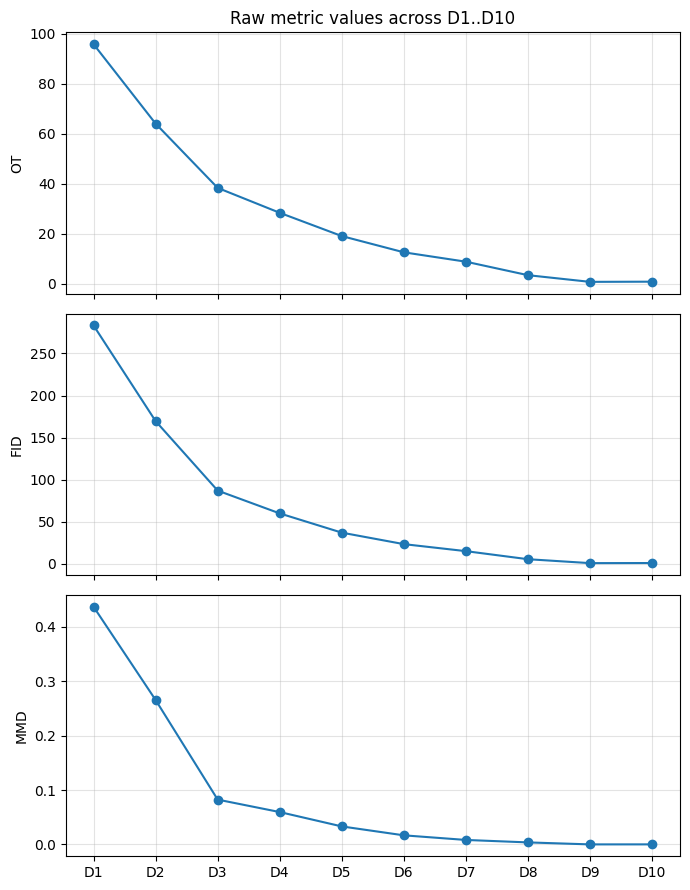

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Choose a metrics DataFrame that exists
candidates = [
    'ot_gen_vs_D_df',         # GEN vs D1..D10 (OT)
    'gen_vs_blur_df',         # GEN vs blurred D1..D10 (FID/OT)
    'blur_df',                # Train vs blurred D1..D10 (FID/OT)
    'scores_df_test_vs_train',# D1..D10 vs train reference (FID/OT/MMD)
    'scores_df'               # fallback
]
for name in candidates:
    if name in globals():
        df = globals()[name].copy()
        print(f"Using DataFrame: {name}")
        break
else:
    raise RuntimeError("No metrics DataFrame found. Define one of the candidates first.")

# 2) Ensure numeric ordering D1..D10 → rank = 1..10 (or create a simple rank)
if 'rank' not in df.columns:
    if 'Di' in df.columns:
        df['rank'] = df['Di'].astype(str).str.extract(r'(\d+)').astype(int)
    else:
        df['rank'] = np.arange(1, len(df)+1)

df = df.sort_values('rank').reset_index(drop=True)
x = df['rank'].to_numpy()
labels = [f"D{i}" for i in x]

# 3) Plot only the metrics that exist
metrics = [m for m in ['OT', 'FID', 'MMD'] if m in df.columns]
fig, axes = plt.subplots(len(metrics), 1, figsize=(7, 3*len(metrics)), sharex=True)

if len(metrics) == 1:
    axes = [axes]  # make iterable

for ax, m in zip(axes, metrics):
    ax.plot(x, df[m].to_numpy(), marker='o')
    ax.set_ylabel(m)
    ax.grid(True, alpha=0.35)

axes[-1].set_xticks(x); axes[-1].set_xticklabels(labels)
axes[0].set_title("Raw metric values across D1..D10")
plt.tight_layout()
plt.show()

### $generated$ $vs$ $d_1,..., d_{10}$

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

[OK] saved 1000 images to ./gen_out_uncond/gen_images.pt and preview.png
    Di                                               name  OT_gen_to_Di
0   D1                D1_test: 1 digit (0), 1 image ×1000     88.372904
1   D2  D2_test: 1 digit, 1000 distinct (digit 1, 1135...     66.712613
2   D3               D3_test: 2 digits, balanced distinct     43.429263
3   D4               D4_test: 3 digits, balanced distinct     33.265928
4   D5               D5_test: 4 digits, balanced distinct     24.826098
5   D6               D6_test: 5 digits, balanced distinct     22.886297
6   D7               D7_test: 6 digits, balanced distinct     21.204496
7   D8               D8_test: 8 digits, balanced distinct     18.707597
8   D9    D9_test: 10 digits, 100 each (with replacement)     16.780913
9  D10             D10_test: 10 digits, 100 each DISTINCT     17.563502
Saved: /content/results/ot_GEN_vs_D1_D10.csv


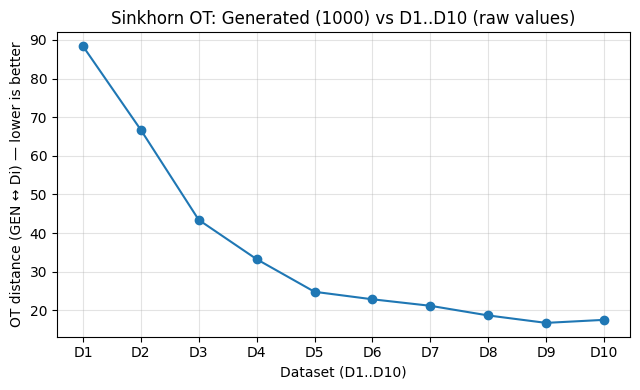

In [ ]:
import os, torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

@torch.no_grad()
def sample_and_save(diffusion, N=1000, B=200, out_dir="./gen_out"):
    os.makedirs(out_dir, exist_ok=True)
    imgs = []
    for s in range(0, N, B):
        b = min(B, N - s)
        x = diffusion.sample(batch_size=b)     # <<< THE call you asked for
        # postprocess to [0,1], (B,1,28,28)
        if x.min() < -0.1 or x.max() > 1.1:
            x = (x + 1) / 2
        x = x.clamp(0, 1)
        if x.shape[1] != 1:
            x = x.mean(1, keepdim=True)
        if x.shape[-2:] != (28, 28):
            x = F.interpolate(x, size=(28, 28), mode="bilinear", align_corners=False)
        imgs.append(x.cpu())

    imgs = torch.cat(imgs, dim=0)
    torch.save(imgs, f"{out_dir}/gen_images.pt")

    grid = make_grid(imgs[:64], nrow=8, padding=2)
    save_image(grid, f"{out_dir}/preview.png")
    print(f"[OK] saved {len(imgs)} images to {out_dir}/gen_images.pt and preview.png")
    return imgs

gen_imgs = sample_and_save(diffusion, N=1000, B=200, out_dir="./gen_out_uncond")

# 0) Get the generated images (prefer in-memory; fall back to file)
def _load_gen_images():
    if "gen_imgs" in globals() and torch.is_tensor(gen_imgs):
        return gen_imgs
    for p in ["./gen_out_uncond/gen_images.pt", "./gen_out/gen_images.pt"]:
        if os.path.exists(p):
            return torch.load(p, map_location="cpu")
    raise FileNotFoundError("Couldn't find generated images. Define `gen_imgs` or save to ./gen_out_uncond/gen_images.pt")

gen_all = _load_gen_images()
assert gen_all.ndim == 4 and gen_all.shape[1:] == (1,28,28), f"Got {tuple(gen_all.shape)}; expected (N,1,28,28)"
gen_imgs_1000 = gen_all[:1000].clone()

# 1) Feature net + standardization (must match your earlier pipeline)
feat_net = SimpleMNISTFeatureNet().to(device).eval()
feat_net.load_state_dict(torch.load(f"{ROOT}/checkpoints/mnist_featnet.pt", map_location=device))
mu    = np.load(f"{ROOT}/features/train_mu.npy")
sigma = np.load(f"{ROOT}/features/train_sigma.npy")

MEAN, STD = 0.1307, 0.3081
def to_mnist_norm(x):
    x = x.detach().float()
    # if accidentally in [-1,1], map to [0,1]
    if float(x.min()) < -0.1 or float(x.max()) > 1.1:
        x = 0.5*(x + 1.0)
    return (x - MEAN) / STD

@torch.no_grad()
def embed_and_standardize(imgs, batch=200):
    imgs = to_mnist_norm(imgs).to(device)
    feats = []
    for i in range(0, len(imgs), batch):
        _, f = feat_net(imgs[i:i+batch])     # pre-ReLU 128-D features
        feats.append(f.detach().cpu())
    feats = torch.cat(feats, 0).numpy()      # [N,128]
    return (feats - mu) / (sigma + 1e-8)

gen_feats = embed_and_standardize(gen_imgs_1000, batch=200)  # [1000,128] standardized

# 2) Pick D1..D10 variants (prefer the TEST-based ones you just built)
if "variants_test" in globals():
    variants_src = variants_test
elif "variants" in globals():
    variants_src = variants
else:
    raise RuntimeError("D1..D10 not found. Please create `variants_test` or `variants` first.")


# 4) Compute OT(gen ↔ Di) for D1..D10 and visualize RAW values
rows = []
for i, ds in enumerate(variants_src, start=1):
    feats_i = ds["feats"]  # standardized [1000,128]
    ot_val = ot_sinkhorn_geomloss(
        torch.from_numpy(gen_feats),
        torch.from_numpy(feats_i),
        backend="tensorized"   # ← was "multiscale"
    )
    rows.append({"Di": f"D{i}", "name": ds["name"], "OT_gen_to_Di": ot_val})

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 5) Build the DataFrame from rows
ot_gen_vs_D_df = pd.DataFrame(rows)

# 6) Ensure correct numeric ordering: D1..D10
ot_gen_vs_D_df["rank"] = ot_gen_vs_D_df["Di"].str.extract(r"D(\d+)").astype(int)
ot_gen_vs_D_df = ot_gen_vs_D_df.sort_values("rank").reset_index(drop=True)
print(ot_gen_vs_D_df[["Di","name","OT_gen_to_Di"]])

# 7) Save + plot (raw values)
os.makedirs(f"{ROOT}/results", exist_ok=True)
csv_path = f"{ROOT}/results/ot_GEN_vs_D1_D10.csv"
ot_gen_vs_D_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

x = ot_gen_vs_D_df["rank"].to_numpy()
y = ot_gen_vs_D_df["OT_gen_to_Di"].to_numpy()

plt.figure(figsize=(6.5,4))
plt.plot(x, y, marker='o')
plt.xticks(x, [f"D{i}" for i in x])
plt.xlabel("Dataset (D1..D10)")
plt.ylabel("OT distance (GEN ↔ Di) — lower is better")
plt.title("Sinkhorn OT: Generated (1000) vs D1..D10 (raw values)")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()



##fidelity/precision:
### $train$ $vs$ $d_1,...d_{10}$

     D  rank  sigma         FID          OT
0   D1     1    0.0    2.118452    1.569918
1   D2     2    0.3    2.062284    1.542398
2   D3     3    0.6   19.572503    9.983416
3   D4     4    0.9   64.888018   31.219718
4   D5     5    1.2  122.148522   55.940492
5   D6     6    1.6  195.666933   84.622927
6   D7     7    2.0  249.304708  104.168010
7   D8     8    2.5  288.653644  118.117975
8   D9     9    3.0  309.177275  125.363614
9  D10    10    3.5  320.362388  129.346545
Saved: /content/results/train_vs_blurred_test_FID_OT.csv


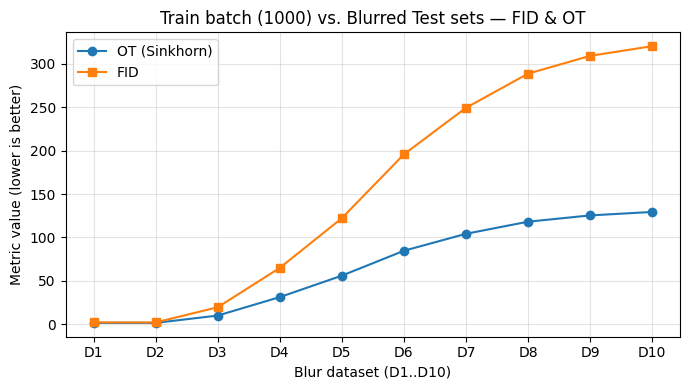

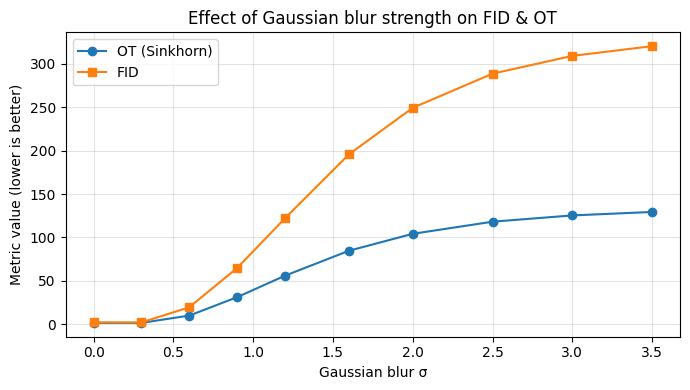

In [ ]:
from torch.utils.data import DataLoader, Subset

rng  = np.random.default_rng(SEED)

# --- Reuse your metric fns and feature net/extractors already defined above:
# - SimpleMNISTFeatureNet
# - extract_feats(model, loader)
# - fid_np(A,B), ot_sinkhorn_geomloss(A,B, backend="tensorized")
# Assumes you already trained/saved the feature net + μ/σ.

# 1) Load standardization stats and the trained feature net
mu    = np.load(f"{ROOT}/features/train_mu.npy")
sigma = np.load(f"{ROOT}/features/train_sigma.npy")
feat_net = SimpleMNISTFeatureNet().to(device).eval()
feat_net.load_state_dict(torch.load(f"{ROOT}/checkpoints/mnist_featnet.pt", map_location=device))
feat_net.eval()

@torch.no_grad()
def embed_loader_std(loader):
    feats = extract_feats(feat_net, loader).numpy()     # [N,128] pre-std
    return (feats - mu) / (sigma + 1e-8)               # standardize with TRAIN stats

# 2) Build the train reference batch (N=1000) by reusing your precomputed standardized TRAIN features
train_std_all = np.load(f"{ROOT}/features/train.npy")   # standardized already
idx_train = rng.choice(len(train_std_all), size=1000, replace=False)
A = train_std_all[idx_train]                            # [1000,128] reference

# 3) Fix a common subset of TEST indices (same images across all blur levels)
#    so the only change is the blur strength.
mnist_test_raw = datasets.MNIST(f"{ROOT}/data", train=False, download=False, transform=transforms.ToTensor())
idx_test = rng.choice(len(mnist_test_raw), size=1000, replace=False)

# 4) Define blur strengths (no-blur baseline + progressively stronger blur)
#    D1 = no blur, D2..D10 = increasing sigma with a 9x9 kernel
sigma_list = [0.0, 0.3, 0.6, 0.9, 1.2, 1.6, 2.0, 2.5, 3.0, 3.5]   # 10 levels
ksize = 9  # must be odd

def make_blur_transform(sigma):
    ops = []
    if sigma > 0:
        ops.append(transforms.GaussianBlur(kernel_size=ksize, sigma=sigma))
    ops += [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
    return transforms.Compose(ops)

# 5) For each blur level: embed TEST subset with that blur, standardize, then compute FID + OT vs A
rows = []
for i, sig in enumerate(sigma_list, start=1):
    tfm_blur = make_blur_transform(sig)
    test_blur = datasets.MNIST(f"{ROOT}/data", train=False, download=False, transform=tfm_blur)
    subset = Subset(test_blur, idx_test)
    loader = DataLoader(subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    B = embed_loader_std(loader)  # [1000,128] standardized
    FID = fid_np(A, B)
    OT  = ot_sinkhorn_geomloss(torch.from_numpy(A), torch.from_numpy(B), backend="tensorized")
    rows.append({"D": f"D{i}", "rank": i, "sigma": sig, "FID": FID, "OT": OT})

blur_df = pd.DataFrame(rows).sort_values("rank").reset_index(drop=True)
print(blur_df)

# 6) Save and plot raw metric values vs blur strength
import os
os.makedirs(f"{ROOT}/results", exist_ok=True)
csv_path = f"{ROOT}/results/train_vs_blurred_test_FID_OT.csv"
blur_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Plots (raw values)
x = blur_df["rank"].to_numpy()
labels = [f"D{i}" for i in x]

plt.figure(figsize=(7,4))
plt.plot(x, blur_df["OT"].to_numpy(),  marker='o', label='OT (Sinkhorn)')
plt.plot(x, blur_df["FID"].to_numpy(), marker='s', label='FID')
plt.xticks(x, labels)
plt.xlabel("Blur dataset (D1..D10)")
plt.ylabel("Metric value (lower is better)")
plt.title("Train batch (1000) vs. Blurred Test sets — FID & OT")
plt.legend()
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

# Optional: plot vs. actual sigma values
plt.figure(figsize=(7,4))
plt.plot(blur_df["sigma"], blur_df["OT"],  marker='o', label='OT (Sinkhorn)')
plt.plot(blur_df["sigma"], blur_df["FID"], marker='s', label='FID')
plt.xlabel("Gaussian blur σ")
plt.ylabel("Metric value (lower is better)")
plt.title("Effect of Gaussian blur strength on FID & OT")
plt.legend()
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()



### $generated$ $vs$ $d_1,...d_{10}$

     D  rank  sigma         FID         OT
0   D1     1    0.0   31.495695  16.700608
1   D2     2    0.3   30.861024  16.384210
2   D3     3    0.6   23.255961  11.964443
3   D4     4    0.9   46.659054  22.164200
4   D5     5    1.2   85.344235  38.969990
5   D6     6    1.6  139.972496  61.330521
6   D7     7    2.0  181.749455  77.484970
7   D8     8    2.5  212.995051  89.227475
8   D9     9    3.0  229.463020  95.378445
9  D10    10    3.5  238.497018  98.777739
Saved: /content/results/GEN_vs_blurred_test_FID_OT.csv


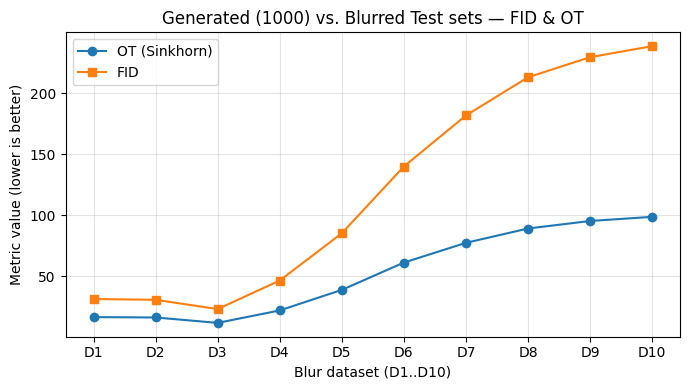

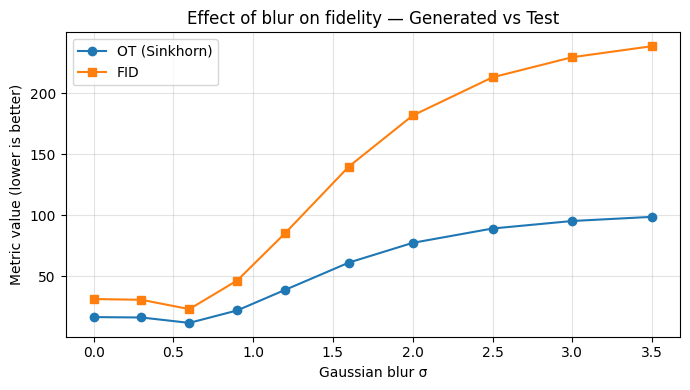

In [ ]:
def _load_gen_images():
    if "gen_imgs" in globals() and torch.is_tensor(gen_imgs):
        return gen_imgs
    for p in ["./gen_out_uncond/gen_images.pt", "./gen_out/gen_images.pt"]:
        if os.path.exists(p):
            return torch.load(p, map_location="cpu")
    raise FileNotFoundError("Couldn't find generated images. Define `gen_imgs` or save to ./gen_out_uncond/gen_images.pt")

gen_all = _load_gen_images()
if gen_all.ndim == 3:
    gen_all = gen_all.unsqueeze(1)
assert gen_all.ndim == 4 and gen_all.shape[1:] == (1,28,28), f"Got {tuple(gen_all.shape)}; expected (N,1,28,28)"
gen_1000 = gen_all[:1000].clone()

feat_net = SimpleMNISTFeatureNet().to(device).eval()
feat_net.load_state_dict(torch.load(f"{ROOT}/checkpoints/mnist_featnet.pt", map_location=device))
mu    = np.load(f"{ROOT}/features/train_mu.npy")
sigma = np.load(f"{ROOT}/features/train_sigma.npy")

MEAN, STD = 0.1307, 0.3081
@torch.no_grad()
def embed_gen_std(imgs, batch=200):
    # imgs may be in [0,1] or [-1,1]; map to MNIST-normalized
    x = imgs.detach().float()
    if float(x.min()) < -0.1 or float(x.max()) > 1.1:
        x = 0.5*(x + 1.0)
    x = (x - MEAN) / STD
    x = x.to(device)
    feats = []
    for i in range(0, len(x), batch):
        _, f = feat_net(x[i:i+batch])      # 128-D pre-ReLU features
        feats.append(f.detach().cpu())
    feats = torch.cat(feats, 0).numpy()
    return (feats - mu) / (sigma + 1e-8)

gen_feats_std = embed_gen_std(gen_1000, batch=200)  # [1000,128]

mnist_test_raw = datasets.MNIST(f"{ROOT}/data", train=False, download=False, transform=transforms.ToTensor())
idx_test = rng.choice(len(mnist_test_raw), size=1000, replace=False)

sigma_list = [0.0, 0.3, 0.6, 0.9, 1.2, 1.6, 2.0, 2.5, 3.0, 3.5]  # D1..D10 (no blur → strong blur)
ksize = 9  # odd

def make_blur_transform(sigma):
    ops = []
    if sigma > 0:
        ops.append(transforms.GaussianBlur(kernel_size=ksize, sigma=sigma))
    ops += [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    return transforms.Compose(ops)

@torch.no_grad()
def embed_loader_std(loader):
    # reuse your extract_feats() util
    feats = extract_feats(feat_net, loader).numpy()
    return (feats - mu) / (sigma + 1e-8)

# ---------- 3) Metrics (reuse your implementations) ----------
# fid_np(A,B), ot_sinkhorn_geomloss(A,B, backend="tensorized") should already be defined

# ---------- 4) Evaluate GEN ↔ Di for i=1..10 ----------
rows = []
for i, sig in enumerate(sigma_list, start=1):
    tfm_blur = make_blur_transform(sig)
    test_blur = datasets.MNIST(f"{ROOT}/data", train=False, download=False, transform=tfm_blur)
    subset = Subset(test_blur, idx_test)
    loader = DataLoader(subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    B = embed_loader_std(loader)                            # [1000,128]
    FID = fid_np(gen_feats_std, B)
    OT  = ot_sinkhorn_geomloss(torch.from_numpy(gen_feats_std), torch.from_numpy(B), backend="tensorized")
    rows.append({"D": f"D{i}", "rank": i, "sigma": sig, "FID": FID, "OT": OT})

gen_vs_blur_df = pd.DataFrame(rows).sort_values("rank").reset_index(drop=True)
print(gen_vs_blur_df)

# ---------- 5) Save + plots ----------
os.makedirs(f"{ROOT}/results", exist_ok=True)
csv_path = f"{ROOT}/results/GEN_vs_blurred_test_FID_OT.csv"
gen_vs_blur_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Raw values vs D1..D10
x = gen_vs_blur_df["rank"].to_numpy()
plt.figure(figsize=(7,4))
plt.plot(x, gen_vs_blur_df["OT"].to_numpy(),  marker='o', label='OT (Sinkhorn)')
plt.plot(x, gen_vs_blur_df["FID"].to_numpy(), marker='s', label='FID')
plt.xticks(x, [f"D{i}" for i in x])
plt.xlabel("Blur dataset (D1..D10)")
plt.ylabel("Metric value (lower is better)")
plt.title("Generated (1000) vs. Blurred Test sets — FID & OT")
plt.legend()
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

# Raw values vs blur sigma
plt.figure(figsize=(7,4))
plt.plot(gen_vs_blur_df["sigma"], gen_vs_blur_df["OT"],  marker='o', label='OT (Sinkhorn)')
plt.plot(gen_vs_blur_df["sigma"], gen_vs_blur_df["FID"], marker='s', label='FID')
plt.xlabel("Gaussian blur σ")
plt.ylabel("Metric value (lower is better)")
plt.title("Effect of blur on fidelity — Generated vs Test")
plt.legend()
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()


## over fitting:

      D  rank  pct_train  n_train  n_test        FID         OT
0    D0     0          0        0    1000  32.429772  17.054936
1    D1     1         10      100     900  32.604396  17.090065
2    D2     2         20      200     800  32.131376  16.803636
3    D3     3         30      300     700  32.575222  16.924815
4    D4     4         40      400     600  31.744652  16.494733
5    D5     5         50      500     500  32.312786  16.857464
6    D6     6         60      600     400  30.134884  15.744987
7    D7     7         70      700     300  31.872263  16.498804
8    D8     8         80      800     200  31.047527  16.263751
9    D9     9         90      900     100  31.130577  16.147766
10  D10    10        100     1000       0  31.410702  16.277302
Saved: /content/results/GEN_vs_mixed_train_test_FID_OT.csv


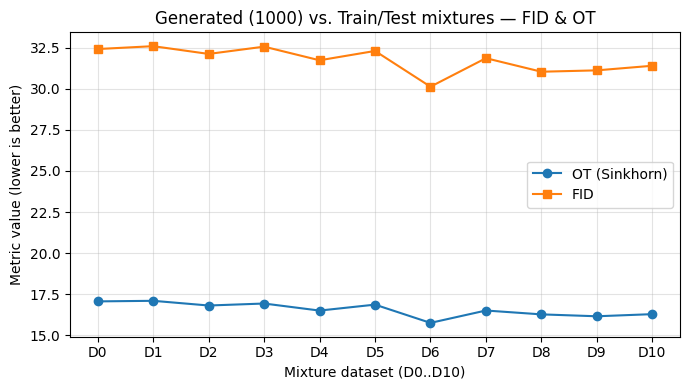

In [ ]:

train_std_all = np.load(f"{ROOT}/features/train.npy")  # [N_train, 128], standardized with train μ/σ
test_std_all  = np.load(f"{ROOT}/features/test.npy")   # [N_test,  128], standardized with train μ/σ

# 1) Get generated features (standardized) of size 1000
#    If 'gen_feats_std' isn't defined yet, uncomment the block to embed from gen_imgs.
assert 'gen_feats_std' in globals() and isinstance(gen_feats_std, np.ndarray), \
    "Expected 'gen_feats_std' (1000x128) in scope. If missing, embed your gen_imgs as you did before."

assert gen_feats_std.shape[0] >= 1000 and gen_feats_std.shape[1] == 128
A = gen_feats_std[:1000]  # [1000,128]

# 2) Fix a pool of 1000 TRAIN and 1000 TEST indices (so only the mix ratio changes)
pool_train_idx = rng.choice(len(train_std_all), size=1000, replace=False)
pool_test_idx  = rng.choice(len(test_std_all),  size=1000, replace=False)

pool_train = train_std_all[pool_train_idx]  # [1000,128]
pool_test  = test_std_all[pool_test_idx]    # [1000,128]

# 3) Build D0..D10 mixtures: Di has i/10 fraction from TRAIN and (1 - i/10) from TEST
def make_mix_set(i, total=1000):
    n_train = int(round(i * total / 10.0))
    n_test  = total - n_train
    # deterministic subsampling per-i for reproducibility
    r1 = np.random.default_rng(SEED + 10_000 + i)
    r2 = np.random.default_rng(SEED + 20_000 + i)
    tr_sel = r1.choice(1000, size=n_train, replace=False)
    te_sel = r2.choice(1000, size=n_test,  replace=False)
    B = np.vstack([pool_train[tr_sel], pool_test[te_sel]])  # [1000,128]
    return B, n_train, n_test

# 4) Evaluate GEN ↔ Di using FID + OT (use tensorized backend to avoid KeOps)
rows = []
for i in range(11):  # D0..D10
    B, ntr, nte = make_mix_set(i, total=1000)
    FID = fid_np(A, B)
    OT  = ot_sinkhorn_geomloss(torch.from_numpy(A), torch.from_numpy(B), backend="tensorized")
    rows.append({
        "D": f"D{i}", "rank": i, "pct_train": 10*i, "n_train": ntr, "n_test": nte,
        "FID": FID, "OT": OT
    })

mix_df = pd.DataFrame(rows).sort_values("rank").reset_index(drop=True)
print(mix_df)

# 5) Save + plot raw metrics vs mixture
os.makedirs(f"{ROOT}/results", exist_ok=True)
csv_path = f"{ROOT}/results/GEN_vs_mixed_train_test_FID_OT.csv"
mix_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Plot vs D0..D10
x = mix_df["rank"].to_numpy()
plt.figure(figsize=(7,4))
plt.plot(x, mix_df["OT"].to_numpy(),  marker='o', label='OT (Sinkhorn)')
plt.plot(x, mix_df["FID"].to_numpy(), marker='s', label='FID')
plt.xticks(x, [f"D{i}" for i in x])
plt.xlabel("Mixture dataset (D0..D10)")
plt.ylabel("Metric value (lower is better)")
plt.title("Generated (1000) vs. Train/Test mixtures — FID & OT")
plt.legend()
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()



## generated vs train for each epoch

In [ ]:
import os, re, math, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt
from glob import glob
ROOT   = "/content"
CHK_DIR = "/content/drive/MyDrive/_ddpm_mnist_checkpoints"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED   = 1337
rng    = np.random.default_rng(SEED)

# Mount Drive if in Colab
try:
    from google.colab import drive  # noqa
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

# ---------------- Load standardized TRAIN/TEST features you saved earlier ----------------
train_std_all = np.load(f"{ROOT}/features/train.npy")  # [N_train, 128]
test_std_all  = np.load(f"{ROOT}/features/test.npy")   # [N_test,  128]

# Fix 1000-sample subsets (so results are comparable across epochs)
idx_train = rng.choice(len(train_std_all), size=1000, replace=False)
idx_test  = rng.choice(len(test_std_all),  size=1000, replace=False)
A_train   = train_std_all[idx_train]  # [1000,128]
B_test    = test_std_all[idx_test]    # [1000,128]

# ---------------- Sinkhorn OT (tensorized backend = no KeOps needed) ----------------
try:
    ot_sinkhorn_geomloss  # reuse if defined
except NameError:
    from geomloss import SamplesLoss
    def _median_pairwise_sqdist_torch(X):
        d2 = torch.cdist(X, X, p=2)**2
        return torch.median(d2[d2>0]).item()
    def ot_sinkhorn_geomloss(A, B, eps=None, backend="tensorized"):
        A = torch.as_tensor(A, dtype=torch.float64)
        B = torch.as_tensor(B, dtype=torch.float64)
        if eps is None:
            eps = 0.1 * _median_pairwise_sqdist_torch(torch.vstack([A,B]))
        blur = math.sqrt(eps)
        loss = SamplesLoss(loss="sinkhorn", p=2, blur=blur, scaling=0.8, debias=True, backend=backend)
        return float(loss(A, B).item())

# Baseline OT(train↔test)
OT_train_test = ot_sinkhorn_geomloss(torch.from_numpy(A_train), torch.from_numpy(B_test), backend="tensorized")
print(f"Baseline OT(train subset ↔ test subset): {OT_train_test:.6f}")

# ---------------- Feature net for embedding generated images ----------------
feat_net = SimpleMNISTFeatureNet().to(device).eval()
feat_net.load_state_dict(torch.load(f"{ROOT}/checkpoints/mnist_featnet.pt", map_location=device))
MEAN, STD = 0.1307, 0.3081
mu    = np.load(f"{ROOT}/features/train_mu.npy")
sigma = np.load(f"{ROOT}/features/train_sigma.npy")

@torch.no_grad()
def embed_gen_and_standardize(imgs, batch=200):
    x = imgs.detach().float()
    if float(x.min()) < -0.1 or float(x.max()) > 1.1:  # handle [-1,1]
        x = 0.5*(x + 1.0)
    x = (x - MEAN) / STD
    x = x.to(device)
    feats = []
    for i in range(0, len(x), batch):
        _, f = feat_net(x[i:i+batch])
        feats.append(f.detach().cpu())
    feats = torch.cat(feats, 0).numpy()  # [N,128]
    return (feats - mu) / (sigma + 1e-8)

# ---------------- Rebuild diffusion, load epoch weights, sample 1000 ----------------
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

def build_or_rebuild_diffusion():
    if "build_model_and_diffusion" in globals():
        m, diff = build_model_and_diffusion(device=device, image_size=28)
        return m.to(device).eval(), diff
    unet = Unet(dim=64, channels=1, dim_mults=(1,2,4))
    diffusion = GaussianDiffusion(
        unet, image_size=28, timesteps=1000, sampling_timesteps=50, objective='pred_noise'
    ).to(device)
    return unet.to(device).eval(), diffusion

@torch.no_grad()
def load_and_sample_epoch(epoch):
    path = os.path.join(CHK_DIR, f"ddpm_epoch{epoch:03d}.pt")
    obj = torch.load(path, map_location=device)
    unet, diffusion = build_or_rebuild_diffusion()
    if isinstance(obj, dict) and "model" in obj:
        unet.load_state_dict(obj["model"], strict=False)
    else:  # naked state_dict
        unet.load_state_dict(obj, strict=False)
    if hasattr(diffusion, "model"):
        diffusion.model.load_state_dict(unet.state_dict(), strict=False)
    # sample 1000 images (try your preferred API first)
    try:
        imgs = diffusion.sample(batch_size=1000)
    except TypeError:
        if hasattr(diffusion, "ddim_sample"):
            imgs = diffusion.ddim_sample((1000,1,28,28))
        elif hasattr(diffusion, "ddpm_sample"):
            imgs = diffusion.ddpm_sample((1000,1,28,28))
        else:
            imgs = diffusion.sample((1000,1,28,28))
    if imgs.ndim == 3:
        imgs = imgs.unsqueeze(1)
    return imgs  # [1000,1,28,28]

Baseline OT(train subset ↔ test subset): 1.569952


Epoch 001 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 002 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 003 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 004 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 005 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 006 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 007 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 008 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 009 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 010 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 011 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 012 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 013 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 014 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 015 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 016 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 017 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 018 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 019 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 020 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 021 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 022 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 023 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 024 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 025 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 026 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 027 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 028 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 029 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 030 …


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

   epoch  OT_gen_train  OT_train_test
0      1     58.385933       1.569952
1      2     20.954426       1.569952
2      3     23.676157       1.569952
3      4     27.346278       1.569952
4      5     19.702894       1.569952
Saved: /content/results/ot_train_test_and_gen_train_over_epochs.csv


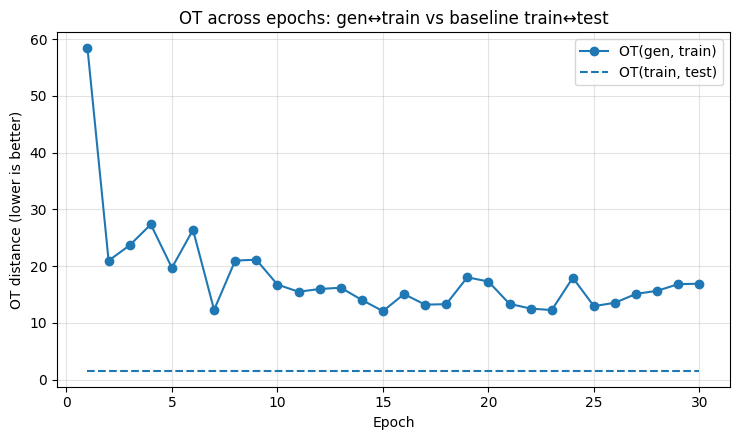

In [ ]:


# ---------------- Iterate epochs and compute OT(gen↔train) ----------------
rows = []
for epoch in range(1, 31):
    print(f"Epoch {epoch:03d} …")
    imgs = load_and_sample_epoch(epoch)                  # [1000,1,28,28]
    gen_feats = embed_gen_and_standardize(imgs)          # [1000,128], standardized
    OT_gen_train = ot_sinkhorn_geomloss(torch.from_numpy(gen_feats),
                                        torch.from_numpy(A_train),
                                        backend="tensorized")
    rows.append({"epoch": epoch, "OT_gen_train": OT_gen_train, "OT_train_test": OT_train_test})

df = pd.DataFrame(rows).sort_values("epoch").reset_index(drop=True)
print(df.head())

# ---------------- Save + plot ----------------
os.makedirs(f"{ROOT}/results", exist_ok=True)
csv_path = f"{ROOT}/results/ot_train_test_and_gen_train_over_epochs.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

plt.figure(figsize=(7.5,4.5))
plt.plot(df["epoch"], df["OT_gen_train"], marker='o', label="OT(gen, train)")
plt.hlines(OT_train_test, xmin=df["epoch"].min(), xmax=df["epoch"].max(),
           linestyles='--', label="OT(train, test)")
plt.xlabel("Epoch")
plt.ylabel("OT distance (lower is better)")
plt.title("OT across epochs: gen↔train vs baseline train↔test")
plt.legend()
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

## Our OT- Model with New Loss: $L$ = $L_{MSE}$ + $w·L_{OT}$







### Configuretions and Settings 

In [ ]:
import os, sys, time, random, string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm

import wandb
import matplotlib.pyplot as plt
from geomloss import SamplesLoss
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

# ===============================
# Basic config
# ===============================
IMAGE_SIZE     = globals().get("IMAGE_SIZE", 28)
BATCH_SIZE     = globals().get("BATCH_SIZE", 128)
ROOT_CKPT_DIR  = globals().get("CHECKPOINT_DIR", "./checkpoints_mnist_full_ot")

EPOCHS      = 35
SAVE_EVERY  = 1
NUM_RECONS  = 20

max_batches = None

# ----- OT config (GeomLoss) -----
LAMBDA_OT   = 0.1
OT_P        = 2
OT_BLUR     = 0.05
OT_BACKEND  = "tensor"
OT_GUIDE_STEPS = getattr(diffusion, "sampling_timesteps", 50)
OT_GUIDE_SCALE = 0.10
OT_GUIDE_REF_N = 128
OT_GUIDE_INNER = 1
DATA_DIR    = "./data"

# ===============================
# Fresh run folder
# ===============================
def _rand_token(n=6):
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=n))

RUN_ID = (
    time.strftime("%Y%m%d-%H%M%S")
    + "-"
    + _rand_token()
    + f"-Ot_lambda-{LAMBDA_OT}-OT_BLUR-{OT_BLUR}-ot-P{OT_P}"
)
CHECKPOINT_DIR = os.path.join(ROOT_CKPT_DIR, RUN_ID)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===============================
# W&B
# ===============================
wandb.init(
    project="ddpm-mnist-train",
    name=f"ddpm-ot-{RUN_ID}",
    config={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "image_size": IMAGE_SIZE,
        "lambda_ot": LAMBDA_OT,
        "ot_p": OT_P,
        "ot_blur": OT_BLUR,
        "ot_backend": OT_BACKEND,
        "run_id": RUN_ID,
        "checkpoint_dir": CHECKPOINT_DIR,
    }
)
wandb.define_metric("epoch")
wandb.define_metric("train_total_loss", step_metric="epoch")
wandb.define_metric("train_base_loss",  step_metric="epoch")
wandb.define_metric("train_ot_loss",    step_metric="epoch")
wandb.define_metric("val_loss",         step_metric="epoch")
# OT series
wandb.define_metric("ot_train_generated", step_metric="epoch")
wandb.define_metric("ot_train_test",      step_metric="epoch")
wandb.define_metric("ot_generated_train", step_metric="epoch")
wandb.define_metric("ot_generated_test",  step_metric="epoch")
wandb.define_metric("ot_generated_train_baseline", step_metric="epoch")
wandb.define_metric("ot_generated_test_baseline",  step_metric="epoch")
# FID series
wandb.define_metric("fid_train_generated", step_metric="epoch")
wandb.define_metric("fid_train_test",      step_metric="epoch")
wandb.define_metric("fid_generated_train", step_metric="epoch")
wandb.define_metric("fid_generated_test",  step_metric="epoch")
# MMD series
wandb.define_metric("mmd_train_generated", step_metric="epoch")
wandb.define_metric("mmd_train_test",      step_metric="epoch")
wandb.define_metric("mmd_generated_train", step_metric="epoch")
wandb.define_metric("mmd_generated_test",  step_metric="epoch")

# ===============================
# Device
# ===============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on", device)

# ===============================
# Data: FULL MNIST (to [-1,1])
# ===============================
_transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Lambda(lambda x: x * 2 - 1),
])

train_dataset = torchvision.datasets.MNIST(
    root=DATA_DIR, train=True, transform=_transform, download=True
)
val_dataset = torchvision.datasets.MNIST(
    root=DATA_DIR, train=False, transform=_transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Helpers to fetch exactly N items
def get_n_from_dataset(ds, n, *, shuffle=True):
    idxs = torch.randperm(len(ds))[:n] if shuffle else torch.arange(n)
    xs = []
    for i in idxs:
        x, _ = ds[int(i)]
        xs.append(x)
    return torch.stack(xs, dim=0)

# Fixed validation images/noise for recon viz
fixed_images = get_n_from_dataset(val_dataset, NUM_RECONS, shuffle=False).to(device)
fixed_noise  = torch.randn_like(fixed_images)
norms = fixed_noise.view(NUM_RECONS, -1).norm(dim=1)
sorted_idx = norms.argsort()
fixed_noise = fixed_noise[sorted_idx]
fixed_images = fixed_images[sorted_idx]

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/noise_mse_t100,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
train/noise_mse_t50,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
train/noise_mse_t900,█▆▃▃▂▃▂▂▂▁▂▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁
train/psnr_t100,▁▃▅▅▅▆▆▆▆▇▇▇▇▇██▇██▇███▇█▇█▇▇█
train/psnr_t50,▁▄▅▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇▇█
train/psnr_t900,▁▅▆▅▇▅▇▇▇█▇▅▇▇█▇█▇▇█████▇▇███▇
val_loss,█▄▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
epoch,30
train/noise_mse_t100,0.07361
train/noise_mse_t50,0.08913


Training on cuda


#### Diffussion Model , OT loss and OT sampling

In [ ]:
# ===============================
# Model & diffusion
# ===============================
def build_model_and_diffusion(device, image_size=IMAGE_SIZE):
    model = Unet(dim=64, dim_mults=(1, 2, 4), channels=1).to(device)
    diffusion = GaussianDiffusion(
        model,
        image_size=image_size,
        timesteps=1000,
        sampling_timesteps=50
    ).to(device)
    return model, diffusion

model, diffusion = build_model_and_diffusion(device=device, image_size=IMAGE_SIZE)

# ===============================
# Optimizer
# ===============================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# ===============================
# GeomLoss object
# ===============================
def _normalize_geomloss_backend(name: str) -> str:
    b = (name or "").lower()
    if b == "tensor":
        b = "tensorized"
    if b not in {"tensorized", "online", "keops"}:
        print(f"[GeomLoss] Unknown backend '{name}', falling back to 'tensorized'.")
        b = "tensorized"
    return b

ot_loss_fn = SamplesLoss(loss="sinkhorn", p=OT_P, blur=OT_BLUR, backend=_normalize_geomloss_backend(OT_BACKEND))
ot_loss_sample=SamplesLoss(loss="sinkhorn", p=1, backend=_normalize_geomloss_backend(OT_BACKEND))
# ========= OT-GUIDED DDIM SAMPLER =========
def _get_ref_batch(n, *, device):
    return get_n_from_dataset(train_dataset, n, shuffle=True).to(device)

def _flat(x):
    return x.reshape(x.shape[0], -1)

@torch.no_grad()
def ddim_sample_with_ot(
    model, diffusion, *,
    n=100, steps=None,
    eta=0.0,
    ot_scale=0.1,
    ot_ref_n=128,
    ot_inner_iters=1
):
    device = next(model.parameters()).device
    steps = steps or getattr(diffusion, "sampling_timesteps", 50)
    T     = diffusion.num_timesteps
    ac    = diffusion.alphas_cumprod.to(device)

    times = torch.linspace(T - 1, 0, steps, dtype=torch.long, device=device)

    x_t = torch.randn(n, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)

    for s, t in enumerate(times):
        t = int(t.item())
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)

        # ᾱ_t and ᾱ_{t-1}
        a_t = ac[t].view(1, 1, 1, 1).expand(n, 1, 1, 1)
        if s < steps - 1:
            a_prev = ac[int(times[s + 1].item())].view(1, 1, 1, 1).expand_as(a_t)
        else:
            a_prev = torch.ones_like(a_t)

        # we need grads through x0_hat for OT, so re-enable autograd here
        with torch.enable_grad():
            x_t = x_t.detach().requires_grad_(True)

            # model prediction and current x0_hat
            eps     = model(x_t, t_batch)
            x0_hat  = ((x_t - torch.sqrt(1 - a_t) * eps) / torch.sqrt(a_t)).clamp(-1, 1)

            # ----- OT guidance on x0_hat (pixels) -----
            for _ in range(ot_inner_iters):
                ref = _get_ref_batch(min(ot_ref_n, n), device=device)
                k = ref.size(0)
                x0_sel = x0_hat[:k]

                # Sinkhorn divergence (empirical) in pixel space
                ot_val = ot_loss_fn(_flat(x0_sel), _flat(ref))

                # grad wrt x0_hat
                grad_x0 = torch.autograd.grad(ot_val, x0_hat, retain_graph=True, create_graph=False)[0]

                # per-sample normalized step (avoid exploding updates)
                gnorm = grad_x0.flatten(1).norm(dim=1, keepdim=True).clamp(min=1e-6).view(-1, 1, 1, 1)
                x0_hat = (x0_hat - ot_scale * grad_x0 / gnorm).clamp(-1, 1)

            # recompute eps from the OT-updated x0_hat (closed form)
            eps = (x_t - torch.sqrt(a_t) * x0_hat) / torch.sqrt(1 - a_t)

        # ----- DDIM update to x_{t-1} -----
        if eta == 0.0:
            x_prev = torch.sqrt(a_prev) * x0_hat + torch.sqrt(1 - a_prev) * eps
        else:
            sigma = eta * torch.sqrt((1 - a_prev) / (1 - a_t)) * torch.sqrt(1 - a_t / a_prev)
            c     = torch.sqrt(1 - a_prev - sigma**2)
            noise = torch.randn_like(x_t)
            x_prev = torch.sqrt(a_prev) * x0_hat + c * eps + sigma * noise

        x_t = x_prev.detach()
    return x_t  # [-1,1]

def sample_many_with_ot(model, diffusion, n_total, *, steps=None, bs=128, eta=0.0,
                        ot_scale=0.1, ot_ref_n=128, ot_inner_iters=1):
    outs = []
    for s in range(0, n_total, bs):
        k = min(bs, n_total - s)
        outs.append(
            ddim_sample_with_ot(
                model, diffusion, n=k, steps=steps, eta=eta,
                ot_scale=ot_scale, ot_ref_n=ot_ref_n, ot_inner_iters=ot_inner_iters
            )
        )
    return torch.cat(outs, dim=0)
# ===============================
# Loss functions
# ===============================
def compute_loss(model, diffusion, x0, device, *, lambda_ot=LAMBDA_OT):
    """
    L_total = L_base + lambda_ot * SinkhornDivergence( x0, x0_hat )
    where x0_hat is reconstructed from predicted noise at a random t.
    """
    b = x0.size(0)
    T_full = diffusion.num_timesteps

    # quadratic timestep sampling
    u = torch.rand(b, device=device)
    t = (u ** 2 * T_full).long().clamp(0, T_full - 1)

    # forward noising
    noise = torch.randn_like(x0)
    x_t = diffusion.q_sample(x_start=x0, t=t, noise=noise)

    # predict noise & base loss
    pred_noise = model(x_t, t)
    base_loss  = F.mse_loss(pred_noise, noise)

    # reconstruct x0_hat
    x0_hat = diffusion.predict_start_from_noise(x_t, t, pred_noise).clamp(-1, 1)

    # flatten one point per image: (B, D)
    x_flat = x0.detach().reshape(b, -1)
    y_flat = x0_hat.reshape(b, -1)

    # Sinkhorn divergence between empirical dists
    l_ot = torch.tensor(0.0, device=device)
    if lambda_ot > 0.0:
        l_ot = ot_loss_fn(x_flat, y_flat)

    total = base_loss + lambda_ot * l_ot
    return total, base_loss.detach(), l_ot.detach()

@torch.no_grad()
def compute_val_loss(model, diffusion, val_loader, device, max_batches=None):
    model.eval()
    total_base = 0.0
    count = 0
    for i, (x, _) in enumerate(val_loader):
        if max_batches is not None and i >= max_batches:
            break
        x = x.to(device)
        _, base, _ = compute_loss(model, diffusion, x, device, lambda_ot=0.0)
        total_base += float(base)
        count += 1
    return total_base / count if count > 0 else float("nan")

@torch.no_grad()
def compute_ot_between(X_a, X_b, device):
    """
    X_a, X_b: tensors (N, C, H, W) in [-1,1]
    Returns Sinkhorn divergence W_p^ε (empirical) using flattened vectors.
    """
    N = min(len(X_a), len(X_b))
    Xa = X_a[:N].to(device).reshape(N, -1)
    Xb = X_b[:N].to(device).reshape(N, -1)
    return ot_loss_sample(Xa, Xb).item()

#### Computing and Plotting Metrics of OT, FID and MMD

In [ ]:
# ===============================
# NEW: FID & MMD helpers (Inception-V3 features)
# ===============================
from torchvision.models.inception import inception_v3, Inception_V3_Weights

from torchvision.models.inception import inception_v3, Inception_V3_Weights

from torchvision.models.inception import inception_v3, Inception_V3_Weights

@torch.no_grad()
def _build_inception(device):
    weights = Inception_V3_Weights.IMAGENET1K_V1
    net = inception_v3(weights=weights)
    net.eval().to(device)

    # 2048-d features by bypassing classifier
    net.dropout = nn.Identity()
    net.fc = nn.Identity()

    # Get mean/std robustly (newer TV uses weights.meta; transforms is a factory)
    if hasattr(weights, "meta") and isinstance(weights.meta, dict):
        mean = weights.meta.get("mean", (0.485, 0.456, 0.406))
        std  = weights.meta.get("std",  (0.229, 0.224, 0.225))
    else:
        mean = (0.485, 0.456, 0.406)
        std  = (0.229, 0.224, 0.225)

    preprocess = T.Compose([
        T.Lambda(lambda x: (x + 1) * 0.5),
        T.Resize(299, antialias=True),
        T.Lambda(lambda x: x.expand(3, *x.shape[1:]) if x.shape[0]==1 else x),
        T.Normalize(mean=mean, std=std),
    ])
    return net, preprocess


@torch.no_grad()
def _inception_acts(batch_imgs, net, preprocess, device, bs=128):
    """batch_imgs: (N,C,H,W) in [-1,1] -> (N,2048) float features on device"""
    feats = []
    N = batch_imgs.size(0)
    for s in range(0, N, bs):
        x = batch_imgs[s:s+bs].cpu()
        x = torch.stack([preprocess(img) for img in x], dim=0).to(device)
        out = net(x)
        if isinstance(out, (tuple, list)):
            out = out[0]
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        feats.append(out)
    return torch.cat(feats, dim=0)


def _cov(x):
    x = x - x.mean(dim=0, keepdim=True)
    return (x.t() @ x) / (x.size(0) - 1)

FID_ON_CPU = True

def _cov_cpu(x_cpu: torch.Tensor):

    x = x_cpu - x_cpu.mean(dim=0, keepdim=True)
    return (x.t() @ x) / max(x.size(0) - 1, 1)

@torch.no_grad()
def _sqrtm_psd_cpu(A_cpu: torch.Tensor, eps: float = 1e-6):
    A = 0.5 * (A_cpu + A_cpu.T)
    vals, vecs = torch.linalg.eigh(A)
    vals = torch.clamp(vals, min=0)
    S = (vecs * (vals.add_(eps).sqrt()).unsqueeze(0)) @ vecs.t()
    return S

@torch.no_grad()
def compute_fid_from_feats(f1, f2):
    """
    f1, f2: (N,2048) torch tensors on any device.
    Computes FID fully on CPU to avoid GPU eigensolver instability.
    """
    if FID_ON_CPU:
        f1c = f1.detach().to(dtype=torch.float64, device="cpu")
        f2c = f2.detach().to(dtype=torch.float64, device="cpu")

        mu1, mu2 = f1c.mean(0), f2c.mean(0)
        sigma1, sigma2 = _cov_cpu(f1c), _cov_cpu(f2c)

        d = sigma1.size(0)
        I = torch.eye(d, dtype=torch.float64)

        # add tiny jitter for numerical stability
        sigma1 = sigma1 + 1e-6 * I
        sigma2 = sigma2 + 1e-6 * I

        s1h = _sqrtm_psd_cpu(sigma1)
        inner = s1h @ sigma2 @ s1h
        inner_sqrt = _sqrtm_psd_cpu(inner)

        diff = (mu1 - mu2)
        fid = diff.dot(diff) + torch.trace(sigma1 + sigma2 - 2 * inner_sqrt)
        return float(fid)
    else:
        # original GPU path (may crash on some CUDA setups)
        mu1, mu2 = f1.mean(0), f2.mean(0)
        sigma1, sigma2 = _cov(f1), _cov(f2)
        d = sigma1.size(0)
        I = torch.eye(d, device=sigma1.device, dtype=sigma1.dtype)
        sigma1 = sigma1 + 1e-6 * I
        sigma2 = sigma2 + 1e-6 * I
        s1h = _sqrtm_psd(sigma1)
        inner = s1h @ sigma2 @ s1h
        inner_sqrt = _sqrtm_psd(inner)
        diff = mu1 - mu2
        fid = diff.dot(diff) + torch.trace(sigma1 + sigma2 - 2 * inner_sqrt)
        return float(fid)

@torch.no_grad()
def _pairwise_sq_dists(x, y):
    x_norm = (x**2).sum(1, keepdim=True)
    y_norm = (y**2).sum(1, keepdim=True).t()
    return x_norm + y_norm - 2.0 * (x @ y.t())

@torch.no_grad()
def compute_mmd_rbf(f1, f2, sigma=None):
    """ unbiased MMD^2 with Gaussian kernel; f1,f2: (N,D) """
    N = f1.size(0)
    M = f2.size(0)
    if sigma is None:
        samp = torch.cat([f1[:min(N, 512)], f2[:min(M, 512)]], dim=0)
        d2 = _pairwise_sq_dists(samp, samp)
        sigma = torch.sqrt(torch.median(d2[d2>0]) / 2.0).clamp(min=1e-6)
    gamma = 1.0 / (2.0 * sigma**2)

    Kxx = torch.exp(-gamma * _pairwise_sq_dists(f1, f1))
    Kyy = torch.exp(-gamma * _pairwise_sq_dists(f2, f2))
    Kxy = torch.exp(-gamma * _pairwise_sq_dists(f1, f2))

    mmd2 = (Kxx.sum()-Kxx.diag().sum())/(N*(N-1)) + (Kyy.sum()-Kyy.diag().sum())/(M*(M-1)) - 2.0*Kxy.mean()
    return float(mmd2)


#### Training loop

Epoch 1/35: 100%|██████████| 469/469 [02:45<00:00,  2.84it/s, avg_base=0.3562, avg_ot=24.3113, avg_total=2.7874]

Epoch 1: total=2.7874 | base=0.3562 | ot=24.3113
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_001.pt


✅ Epoch 1: val loss = 0.1899


Epoch 2/35: 100%|██████████| 469/469 [02:45<00:00,  2.84it/s, avg_base=0.1527, avg_ot=18.6484, avg_total=2.0175]

Epoch 2: total=2.0175 | base=0.1527 | ot=18.6484
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_002.pt


✅ Epoch 2: val loss = 0.1414


Epoch 3/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.1212, avg_ot=17.0964, avg_total=1.8308]

Epoch 3: total=1.8308 | base=0.1212 | ot=17.0964
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_003.pt


✅ Epoch 3: val loss = 0.1086


Epoch 4/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.1052, avg_ot=16.3678, avg_total=1.7420]

Epoch 4: total=1.7420 | base=0.1052 | ot=16.3678
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_004.pt


✅ Epoch 4: val loss = 0.0952


Epoch 5/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0964, avg_ot=15.9000, avg_total=1.6864]

Epoch 5: total=1.6864 | base=0.0964 | ot=15.9000
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_005.pt


✅ Epoch 5: val loss = 0.0901


Epoch 6/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0909, avg_ot=15.8315, avg_total=1.6740]

Epoch 6: total=1.6740 | base=0.0909 | ot=15.8315
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_006.pt


✅ Epoch 6: val loss = 0.0916


Epoch 7/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0842, avg_ot=15.5367, avg_total=1.6379]

Epoch 7: total=1.6379 | base=0.0842 | ot=15.5367
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_007.pt


✅ Epoch 7: val loss = 0.0814


Epoch 8/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0811, avg_ot=15.2589, avg_total=1.6070]

Epoch 8: total=1.6070 | base=0.0811 | ot=15.2589
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_008.pt


✅ Epoch 8: val loss = 0.0784


Epoch 9/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0790, avg_ot=15.3989, avg_total=1.6189]

Epoch 9: total=1.6189 | base=0.0790 | ot=15.3989
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_009.pt


✅ Epoch 9: val loss = 0.0778


Epoch 10/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0764, avg_ot=15.2182, avg_total=1.5983]

Epoch 10: total=1.5983 | base=0.0764 | ot=15.2182
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_010.pt


✅ Epoch 10: val loss = 0.0746


Epoch 11/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0774, avg_ot=15.1092, avg_total=1.5883]

Epoch 11: total=1.5883 | base=0.0774 | ot=15.1092
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_011.pt


✅ Epoch 11: val loss = 0.0740


Epoch 12/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0737, avg_ot=14.9140, avg_total=1.5651]

Epoch 12: total=1.5651 | base=0.0737 | ot=14.9140
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_012.pt


✅ Epoch 12: val loss = 0.0732


Epoch 13/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0735, avg_ot=14.8539, avg_total=1.5589]

Epoch 13: total=1.5589 | base=0.0735 | ot=14.8539
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_013.pt


✅ Epoch 13: val loss = 0.0701


Epoch 14/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0717, avg_ot=14.7795, avg_total=1.5497]

Epoch 14: total=1.5497 | base=0.0717 | ot=14.7795
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_014.pt


✅ Epoch 14: val loss = 0.0679


Epoch 15/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0713, avg_ot=14.6088, avg_total=1.5322]

Epoch 15: total=1.5322 | base=0.0713 | ot=14.6088
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_015.pt


✅ Epoch 15: val loss = 0.0722


Epoch 16/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0700, avg_ot=14.9488, avg_total=1.5648]

Epoch 16: total=1.5648 | base=0.0700 | ot=14.9488
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_016.pt


✅ Epoch 16: val loss = 0.0666


Epoch 17/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0691, avg_ot=14.7776, avg_total=1.5468]

Epoch 17: total=1.5468 | base=0.0691 | ot=14.7776
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_017.pt


✅ Epoch 17: val loss = 0.0674


Epoch 18/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0686, avg_ot=14.6019, avg_total=1.5288]

Epoch 18: total=1.5288 | base=0.0686 | ot=14.6019
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_018.pt


✅ Epoch 18: val loss = 0.0745


Epoch 19/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0686, avg_ot=14.3800, avg_total=1.5066]

Epoch 19: total=1.5066 | base=0.0686 | ot=14.3800
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_019.pt


✅ Epoch 19: val loss = 0.0686


Epoch 20/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0673, avg_ot=14.3575, avg_total=1.5031]

Epoch 20: total=1.5031 | base=0.0673 | ot=14.3575
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_020.pt


✅ Epoch 20: val loss = 0.0651


Epoch 21/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0681, avg_ot=14.6183, avg_total=1.5299]

Epoch 21: total=1.5299 | base=0.0681 | ot=14.6183
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_021.pt


✅ Epoch 21: val loss = 0.0681


/tmp/ipython-input-25-1796771129.py:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,4.5))
/tmp/ipython-input-25-1796771129.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,4.5))
/tmp/ipython-input-25-1796771129.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much 

Epoch 22: total=1.5154 | base=0.0662 | ot=14.4918
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_022.pt


✅ Epoch 22: val loss = 0.0660


Epoch 23/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0661, avg_ot=14.4666, avg_total=1.5127]

Epoch 23: total=1.5127 | base=0.0661 | ot=14.4666
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_023.pt


✅ Epoch 23: val loss = 0.0659


Epoch 24/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0660, avg_ot=14.1947, avg_total=1.4855]

Epoch 24: total=1.4855 | base=0.0660 | ot=14.1947
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_024.pt


✅ Epoch 24: val loss = 0.0640


Epoch 25/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0655, avg_ot=14.4992, avg_total=1.5154]

Epoch 25: total=1.5154 | base=0.0655 | ot=14.4992
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_025.pt


✅ Epoch 25: val loss = 0.0648


Epoch 26/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0653, avg_ot=14.4090, avg_total=1.5062]

Epoch 26: total=1.5062 | base=0.0653 | ot=14.4090
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_026.pt


✅ Epoch 26: val loss = 0.0632


Epoch 27/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0647, avg_ot=14.3691, avg_total=1.5016]

Epoch 27: total=1.5016 | base=0.0647 | ot=14.3691
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_027.pt


✅ Epoch 27: val loss = 0.0647


Epoch 28/35: 100%|██████████| 469/469 [02:45<00:00,  2.84it/s, avg_base=0.0639, avg_ot=14.2874, avg_total=1.4926]

Epoch 28: total=1.4926 | base=0.0639 | ot=14.2874
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_028.pt


✅ Epoch 28: val loss = 0.0638


Epoch 29/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0646, avg_ot=14.3091, avg_total=1.4955]

Epoch 29: total=1.4955 | base=0.0646 | ot=14.3091
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_029.pt


✅ Epoch 29: val loss = 0.0641


Epoch 30/35: 100%|██████████| 469/469 [02:45<00:00,  2.84it/s, avg_base=0.0640, avg_ot=14.2929, avg_total=1.4933]

Epoch 30: total=1.4933 | base=0.0640 | ot=14.2929
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_030.pt


✅ Epoch 30: val loss = 0.0629


Epoch 31/35: 100%|██████████| 469/469 [02:45<00:00,  2.84it/s, avg_base=0.0643, avg_ot=14.3215, avg_total=1.4965]

Epoch 31: total=1.4965 | base=0.0643 | ot=14.3215
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_031.pt


✅ Epoch 31: val loss = 0.0625


Epoch 32/35: 100%|██████████| 469/469 [02:45<00:00,  2.84it/s, avg_base=0.0635, avg_ot=14.1676, avg_total=1.4802]

Epoch 32: total=1.4802 | base=0.0635 | ot=14.1676
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_032.pt


✅ Epoch 32: val loss = 0.0634


Epoch 33/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0635, avg_ot=14.1384, avg_total=1.4774]

Epoch 33: total=1.4774 | base=0.0635 | ot=14.1384
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_033.pt


✅ Epoch 33: val loss = 0.0640


Epoch 34/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0632, avg_ot=14.2556, avg_total=1.4888]

Epoch 34: total=1.4888 | base=0.0632 | ot=14.2556
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_034.pt


✅ Epoch 34: val loss = 0.0642


Epoch 35/35: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s, avg_base=0.0636, avg_ot=14.0942, avg_total=1.4730]

Epoch 35: total=1.4730 | base=0.0636 | ot=14.0942
Checkpoint saved: /content/drive/MyDrive/_ddpm_mnist_checkpoints/20251016-003055-wtnvf3-Ot_lambda-0.1-OT_BLUR-0.05-ot-P2/ddpm_epoch_035.pt


✅ Epoch 35: val loss = 0.0621


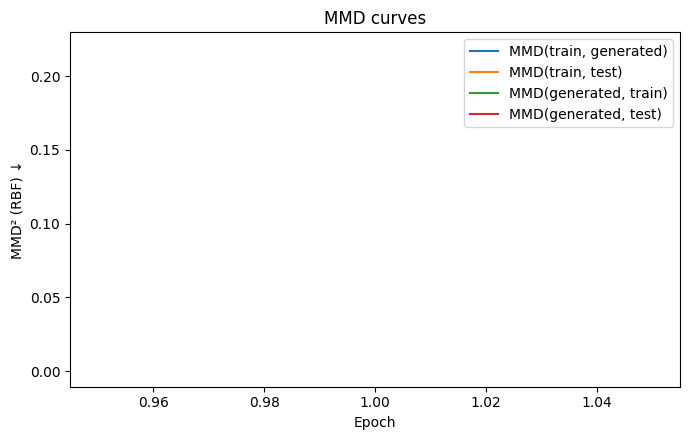

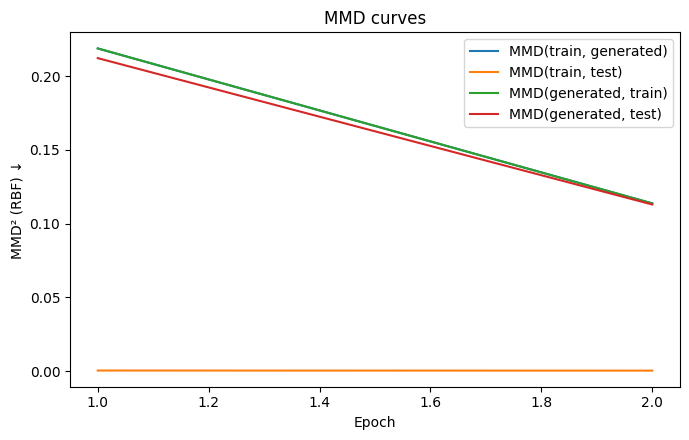

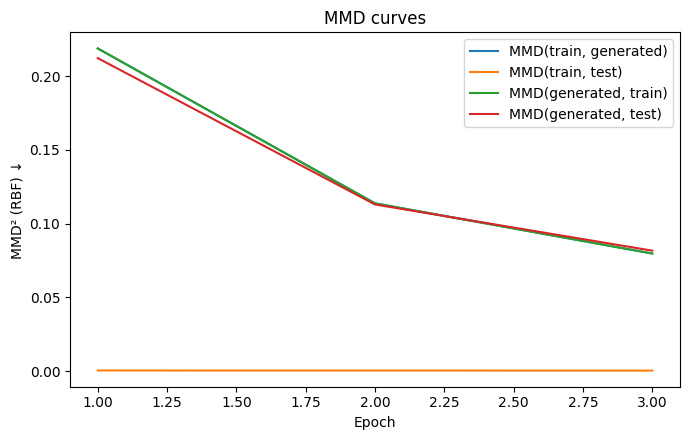

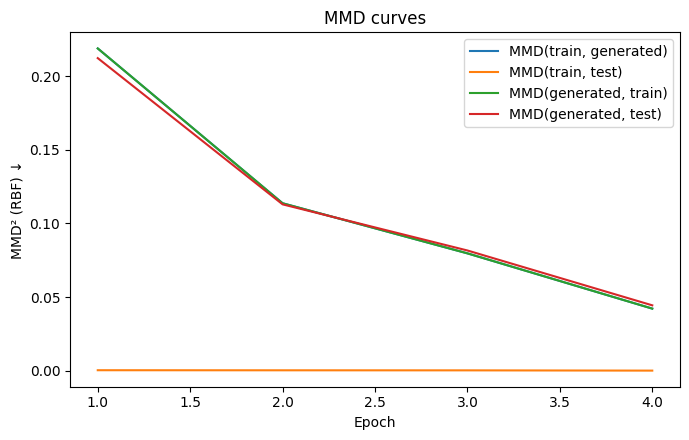

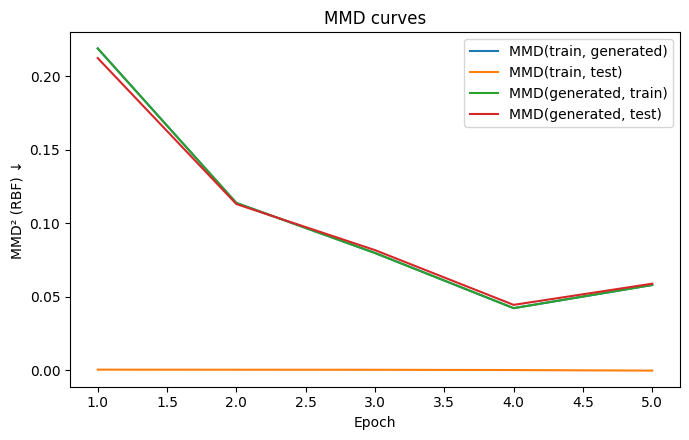

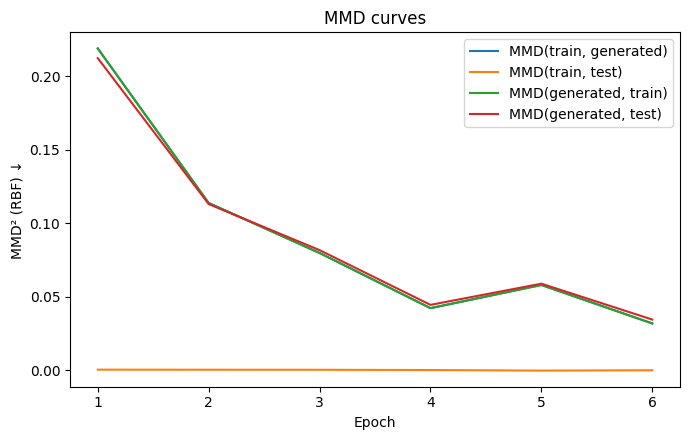

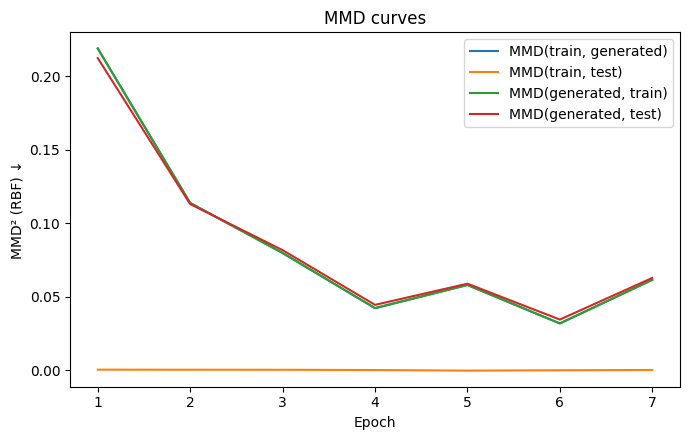

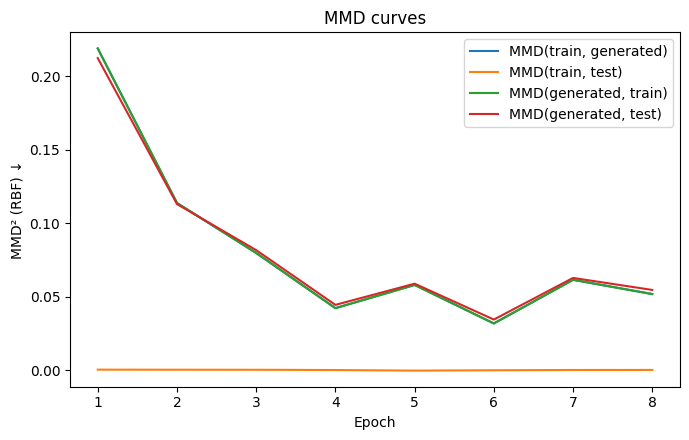

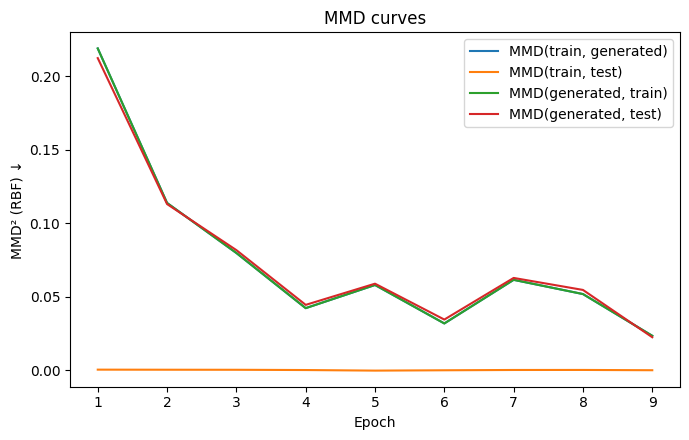

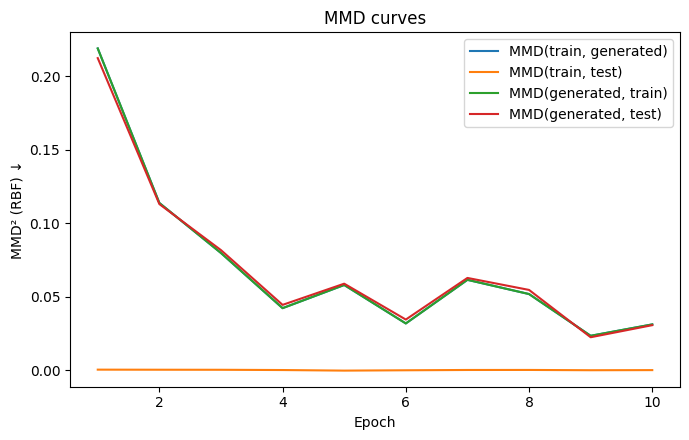

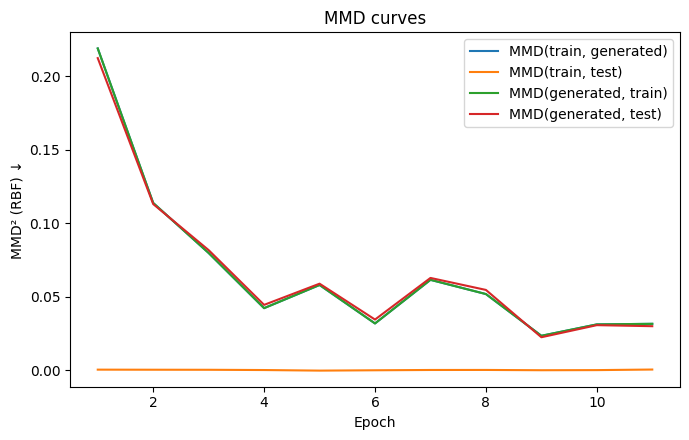

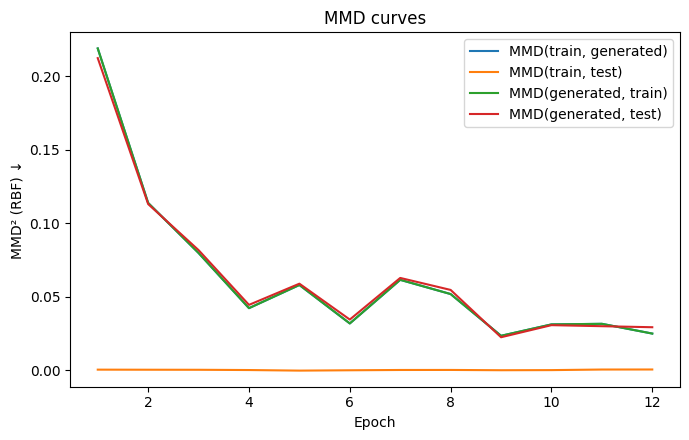

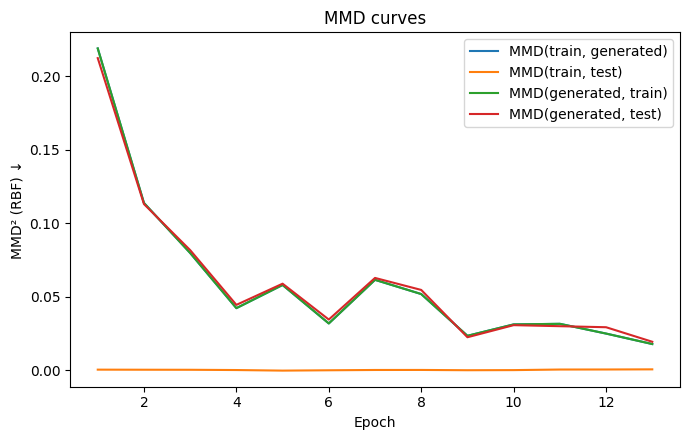

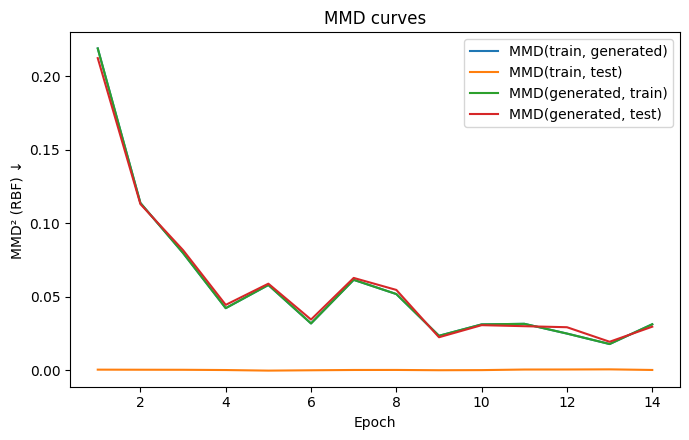

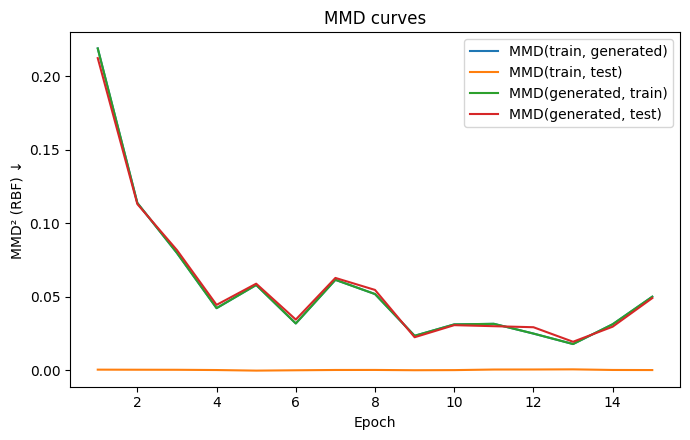

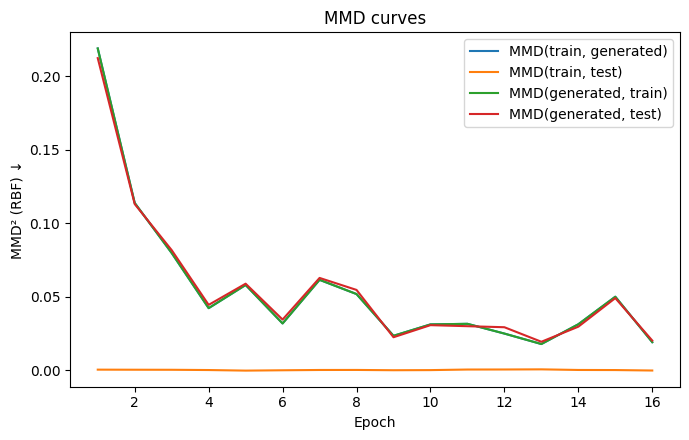

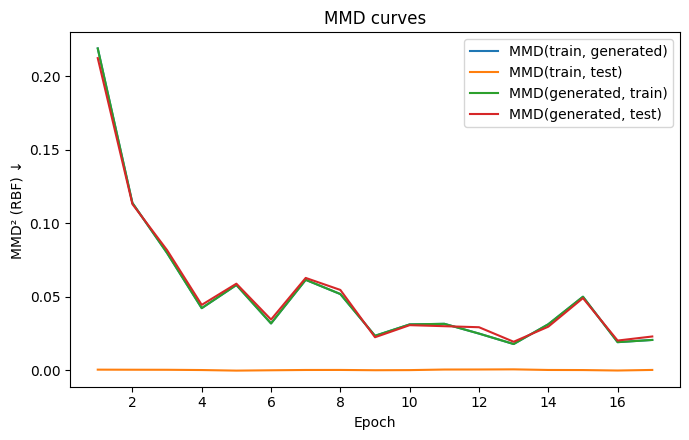

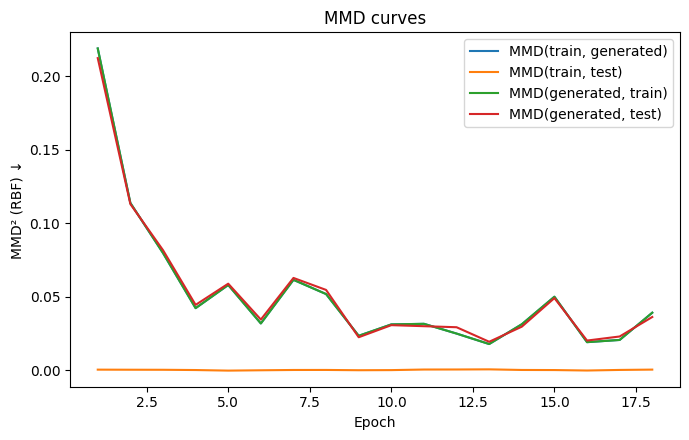

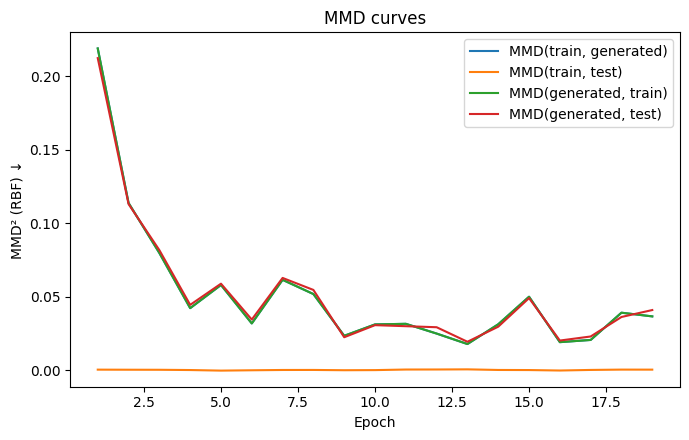

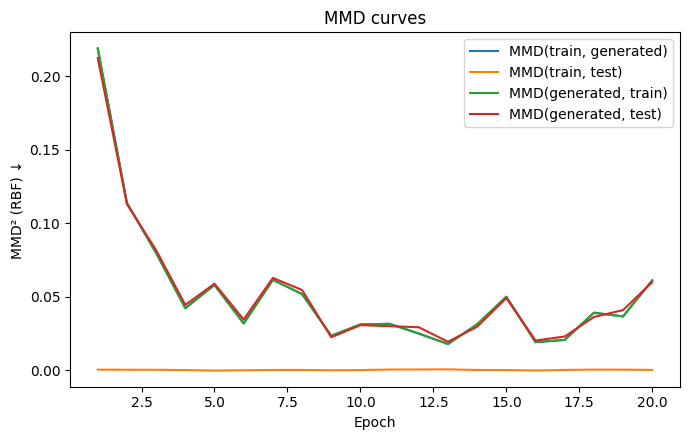

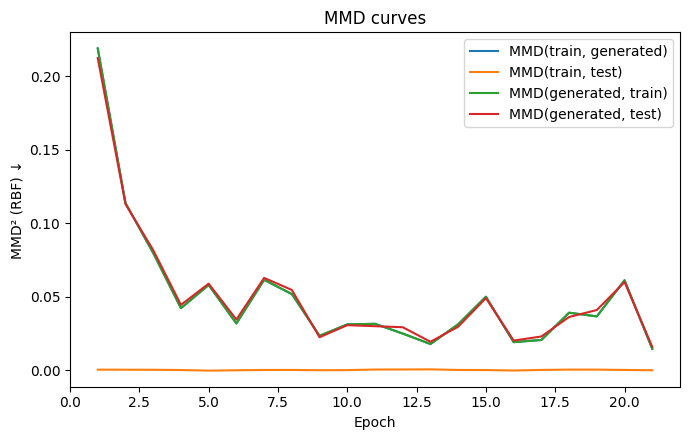

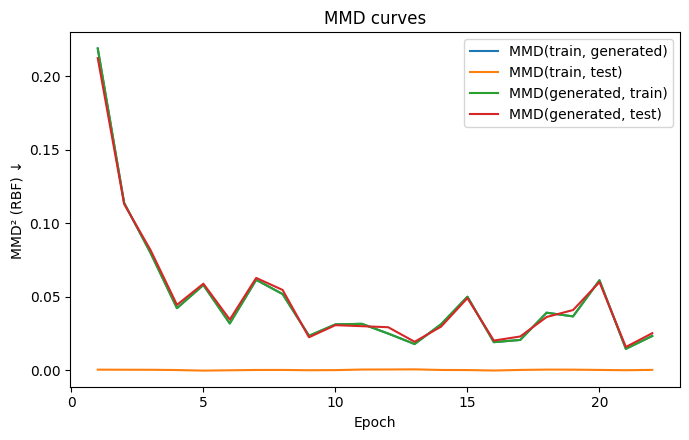

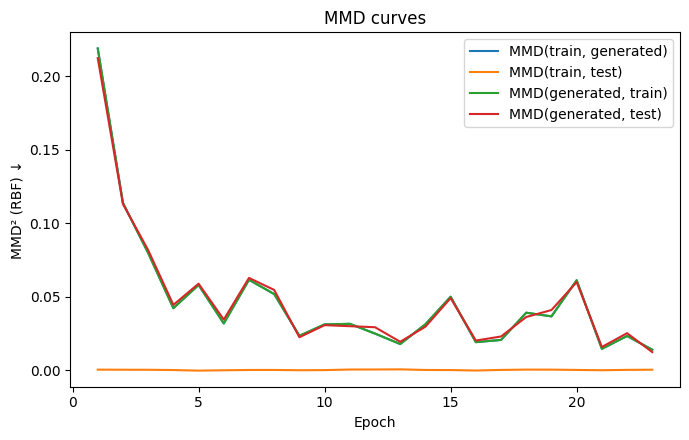

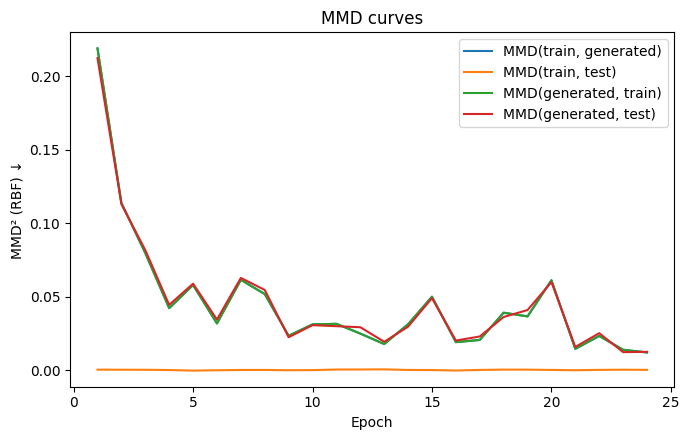

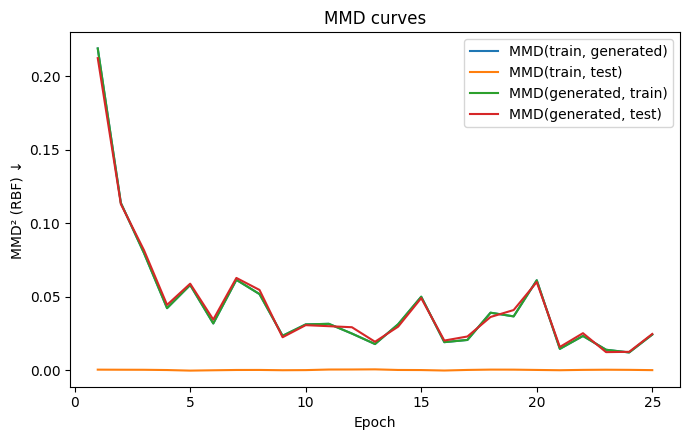

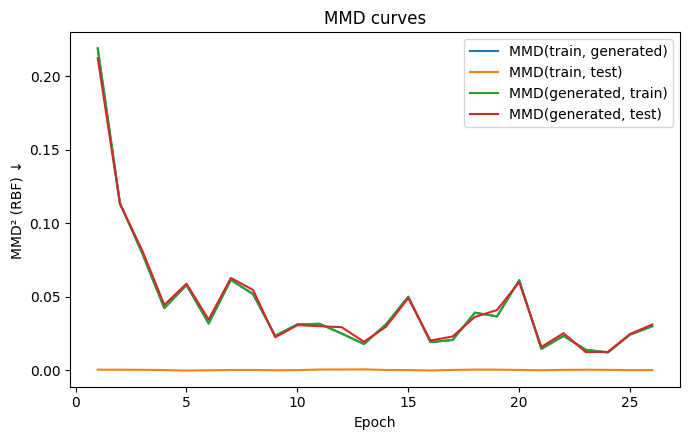

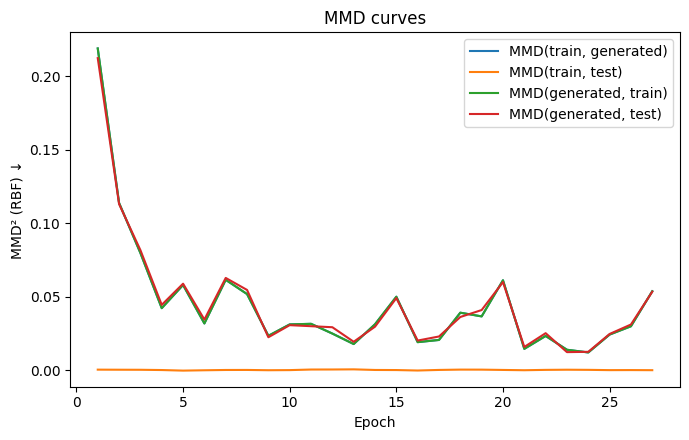

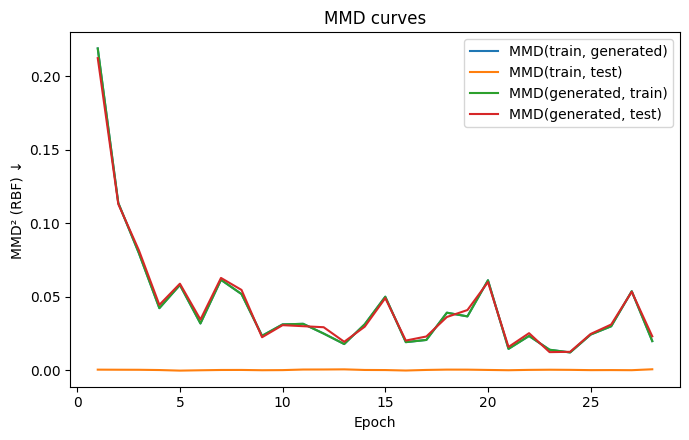

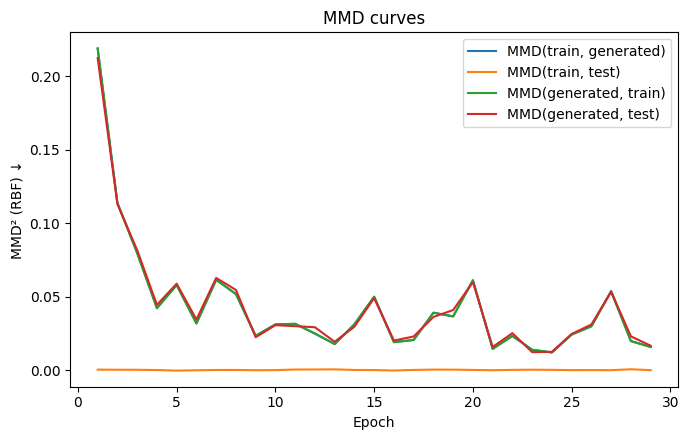

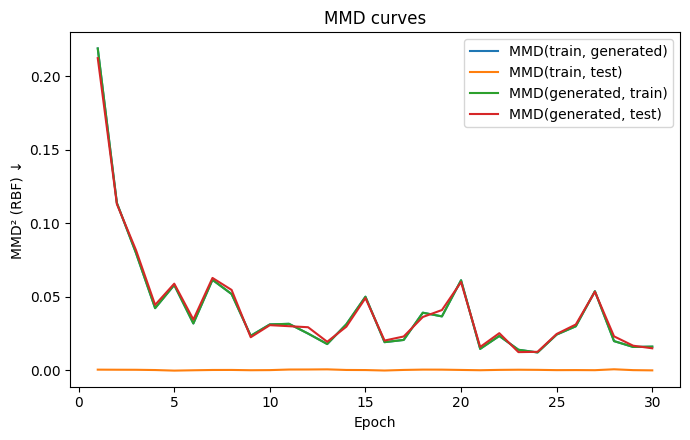

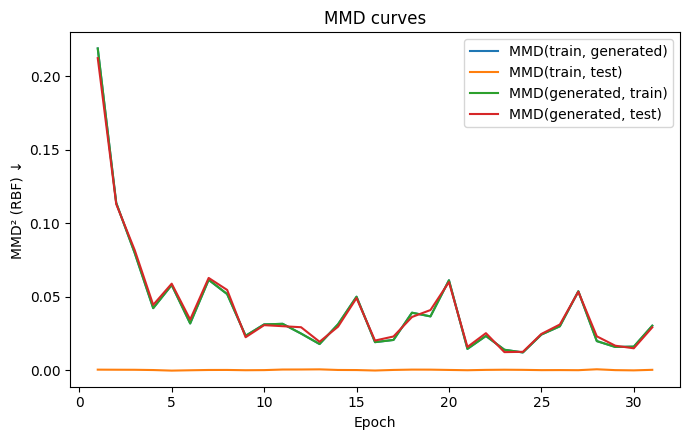

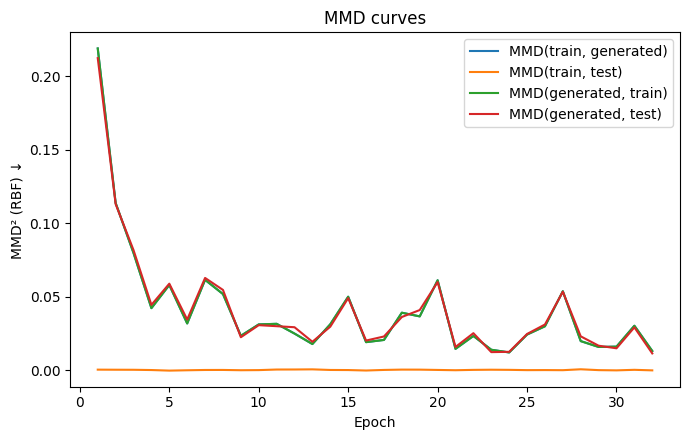

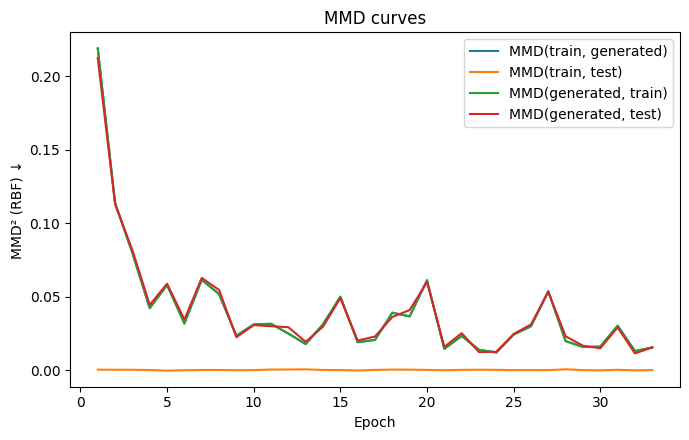

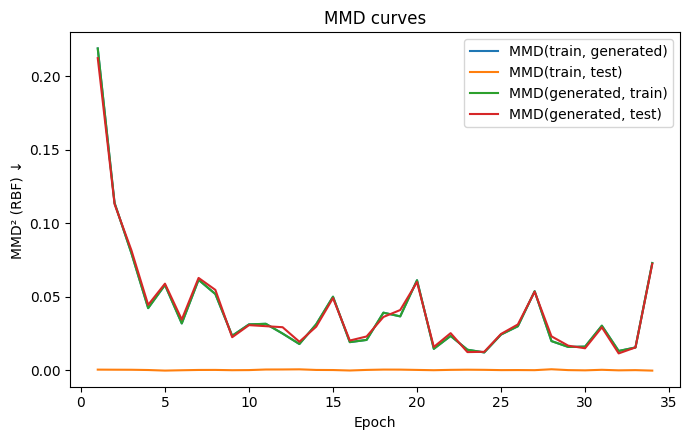

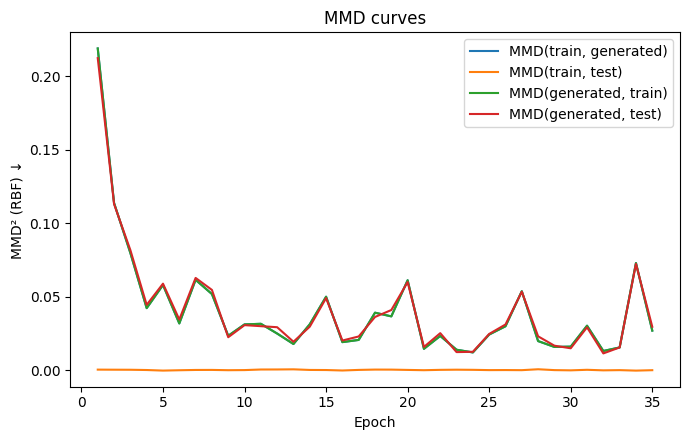

In [ ]:
# ===============================
# Training (ALWAYS from scratch)
# ===============================
start_epoch = 1
# OT histories
ot_hist_tg   = []  # train vs generated
ot_hist_tt   = []  # train vs test
ot_hist_gt   = []  # generated vs train (redundant but requested)
ot_hist_gtest= []  # generated vs test

# FID histories
fid_hist_tg    = []
fid_hist_tt    = []
fid_hist_gt    = []
fid_hist_gtest = []

# MMD histories
mmd_hist_tg    = []
mmd_hist_tt    = []
mmd_hist_gt    = []
mmd_hist_gtest = []

# Build Inception once
inception_net, inception_pre = _build_inception(device)

for epoch in range(start_epoch, EPOCHS + 1):
    ckpt_name = f"ddpm_epoch_{epoch:03d}.pt"
    ckpt_path = os.path.join(CHECKPOINT_DIR, ckpt_name)

    # --- Train this epoch ---
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")

    total_epoch = 0.0
    base_epoch  = 0.0
    ot_epoch    = 0.0
    step_count  = 0

    for i, (x, _) in enumerate(pbar):
        if max_batches is not None and i >= max_batches:
            break

        x0 = x.to(device)

        total, base, ot = compute_loss(model, diffusion, x0, device, lambda_ot=LAMBDA_OT)

        total.backward()
        optimizer.step()
        optimizer.zero_grad()

        step_count  += 1
        total_epoch += float(total)
        base_epoch  += float(base)
        ot_epoch    += float(ot)

        # show running averages in the bar
        avg_total = total_epoch / step_count
        avg_base  = base_epoch  / step_count
        avg_ot    = ot_epoch    / step_count
        pbar.set_postfix(avg_total=f"{avg_total:.4f}", avg_base=f"{avg_base:.4f}", avg_ot=f"{avg_ot:.4f}")

    # ---- epoch-only logging ----
    if step_count > 0:
        avg_total = total_epoch / step_count
        avg_base  = base_epoch  / step_count
        avg_ot    = ot_epoch    / step_count
    else:
        avg_total = float("nan")
        avg_base  = float("nan")
        avg_ot    = float("nan")

    wandb.log({
        "epoch": epoch,
        "train_total_loss": avg_total,
        "train_base_loss":  avg_base,
        "train_ot_loss":    avg_ot,
    })

    print(f"Epoch {epoch}: total={avg_total:.4f} | base={avg_base:.4f} | ot={avg_ot:.4f}")

    # ---- Checkpoint ----
    if epoch % SAVE_EVERY == 0:
        torch.save({"epoch": epoch, "model": model.state_dict()}, ckpt_path)
        print("Checkpoint saved:", ckpt_path)

  # ---- Sampling preview (always OT-guided) ----
    if epoch % SAVE_EVERY == 0:
        model.eval()
        with torch.no_grad():
            real_images = next(iter(val_loader))[0][:100].to(device)

        # OT-guided samples
        sampled_ot = ddim_sample_with_ot(
            model, diffusion,
            n=100, steps=OT_GUIDE_STEPS, eta=0.0,
            ot_scale=OT_GUIDE_SCALE, ot_ref_n=OT_GUIDE_REF_N, ot_inner_iters=OT_GUIDE_INNER
        )

        grid_real = make_grid((real_images * 255).round().to(torch.uint8), nrow=10, pad_value=255)
        grid_ot   = make_grid((((sampled_ot + 1)*0.5).clamp(0,1) * 255).round().to(torch.uint8), nrow=10, pad_value=255)

        wandb.log({
            "epoch": epoch,
            "real_images":    wandb.Image(grid_real, caption=f"Real (Epoch {epoch})"),
            "samples_ot":     wandb.Image(grid_ot,   caption=f"DDIM + OT (Epoch {epoch})"),
        })

    # ---- Validation (epoch-only base loss) ----
    if epoch % SAVE_EVERY == 0:
        val_loss = compute_val_loss(model, diffusion, val_loader, device)
        wandb.log({"epoch": epoch, "val_loss": val_loss})
        print(f"✅ Epoch {epoch}: val loss = {val_loss:.4f}")

    # ---- OT + FID + MMD evaluation on 1k images per split ----
    model.eval()
    with torch.no_grad():
        N_EVAL = 1000

        # prepare sets
        X_train_1k = get_n_from_dataset(train_dataset, N_EVAL, shuffle=True).to(device)
        X_gen_1k = sample_many_with_ot(
    model, diffusion, N_EVAL,
    steps=OT_GUIDE_STEPS, bs=128, eta=0.0,
    ot_scale=OT_GUIDE_SCALE, ot_ref_n=OT_GUIDE_REF_N, ot_inner_iters=OT_GUIDE_INNER
).to(device)
        X_test_1k  = get_n_from_dataset(val_dataset,   N_EVAL, shuffle=True).to(device)

        # --- OT (Sinkhorn divergence) ---
        ot_tg   = compute_ot_between(X_train_1k, X_gen_1k, device)    # train vs generated
        ot_tt   = compute_ot_between(X_train_1k, X_test_1k, device)   # train vs test
        ot_gt   = compute_ot_between(X_gen_1k,   X_train_1k, device)  # generated vs train
        ot_gtes = compute_ot_between(X_gen_1k,   X_test_1k, device)   # generated vs test

        ot_hist_tg.append(ot_tg)
        ot_hist_tt.append(ot_tt)
        ot_hist_gt.append(ot_gt)
        ot_hist_gtest.append(ot_gtes)

        wandb.log({
            "epoch": epoch,
            "ot_train_generated": ot_tg,
            "ot_train_test":      ot_tt,
            "ot_generated_train": ot_gt,
            "ot_generated_test":  ot_gtes,
        })

        plt.figure(figsize=(7,4.5))
        xs = list(range(1, len(ot_hist_tg) + 1))
        plt.plot(xs, ot_hist_tg,    label="OT(train, generated)")
        plt.plot(xs, ot_hist_tt,    label="OT(train, test)")
        plt.plot(xs, ot_hist_gt,    label="OT(generated, train)")
        plt.plot(xs, ot_hist_gtest, label="OT(generated, test)")
        plt.xlabel("Epoch"); plt.ylabel("Sinkhorn divergence"); plt.title("OT curves")
        plt.legend(); plt.tight_layout()
        wandb.log({"OT_curves": wandb.Image(plt)})
        plt.close()

        # --- FID & MMD on Inception features ---
        # features
        f_train = _inception_acts(X_train_1k, inception_net, inception_pre, device)
        f_gen   = _inception_acts(X_gen_1k,   inception_net, inception_pre, device)
        f_test  = _inception_acts(X_test_1k,  inception_net, inception_pre, device)

        # FID for the same pairs
        fid_tg    = compute_fid_from_feats(f_train, f_gen)
        fid_tt    = compute_fid_from_feats(f_train, f_test)
        fid_gt    = compute_fid_from_feats(f_gen,   f_train)
        fid_gtest = compute_fid_from_feats(f_gen,   f_test)

        fid_hist_tg.append(fid_tg)
        fid_hist_tt.append(fid_tt)
        fid_hist_gt.append(fid_gt)
        fid_hist_gtest.append(fid_gtest)

        wandb.log({
            "epoch": epoch,
            "fid_train_generated": fid_tg,
            "fid_train_test":      fid_tt,
            "fid_generated_train": fid_gt,
            "fid_generated_test":  fid_gtest,
        })

        plt.figure(figsize=(7,4.5))
        xs = list(range(1, len(fid_hist_tg) + 1))
        plt.plot(xs, fid_hist_tg,    label="FID(train, generated)")
        plt.plot(xs, fid_hist_tt,    label="FID(train, test)")
        plt.plot(xs, fid_hist_gt,    label="FID(generated, train)")
        plt.plot(xs, fid_hist_gtest, label="FID(generated, test)")
        plt.xlabel("Epoch"); plt.ylabel("FID ↓"); plt.title("FID curves")
        plt.legend(); plt.tight_layout()
        wandb.log({"FID_curves": wandb.Image(plt)})
        plt.close()

        # MMD on the same features (RBF with median heuristic)
        mmd_tg    = compute_mmd_rbf(f_train, f_gen)
        mmd_tt    = compute_mmd_rbf(f_train, f_test)
        mmd_gt    = compute_mmd_rbf(f_gen,   f_train)
        mmd_gtest = compute_mmd_rbf(f_gen,   f_test)

        mmd_hist_tg.append(mmd_tg)
        mmd_hist_tt.append(mmd_tt)
        mmd_hist_gt.append(mmd_gt)
        mmd_hist_gtest.append(mmd_gtest)

        wandb.log({
            "epoch": epoch,
            "mmd_train_generated": mmd_tg,
            "mmd_train_test":      mmd_tt,
            "mmd_generated_train": mmd_gt,
            "mmd_generated_test":  mmd_gtest,
        })

        plt.figure(figsize=(7,4.5))
        xs = list(range(1, len(mmd_hist_tg) + 1))
        plt.plot(xs, mmd_hist_tg,    label="MMD(train, generated)")
        plt.plot(xs, mmd_hist_tt,    label="MMD(train, test)")
        plt.plot(xs, mmd_hist_gt,    label="MMD(generated, train)")
        plt.plot(xs, mmd_hist_gtest, label="MMD(generated, test)")
        plt.xlabel("Epoch"); plt.ylabel("MMD² (RBF) ↓"); plt.title("MMD curves")
        plt.legend(); plt.tight_layout()
        wandb.log({"MMD_curves": wandb.Image(plt)})